# Session 2 - Training a Network w/ Tensorflow
<p class="lead">
Assignment: Teach a Deep Neural Network to Paint
</p>

<p class="lead">
Parag K. Mital<br />
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning w/ Tensorflow</a><br />
<a href="https://www.kadenze.com/partners/kadenze-academy">Kadenze Academy</a><br />
<a href="https://twitter.com/hashtag/CADL">#CADL</a>
</p>

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Learning Goals

* Learn how to create a Neural Network
* Learn to use a neural network to paint an image
* Apply creative thinking to the inputs, outputs, and definition of a network

# Outline

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Assignment Synopsis](#assignment-synopsis)
- [Part One - Fully Connected Network](#part-one---fully-connected-network)
    - [Instructions](#instructions)
    - [Code](#code)
    - [Variable Scopes](#variable-scopes)
- [Part Two - Image Painting Network](#part-two---image-painting-network)
    - [Instructions](#instructions-1)
    - [Preparing the Data](#preparing-the-data)
    - [Cost Function](#cost-function)
    - [Explore](#explore)
    - [A Note on Crossvalidation](#a-note-on-crossvalidation)
- [Part Three - Learning More than One Image](#part-three---learning-more-than-one-image)
    - [Instructions](#instructions-2)
    - [Code](#code-1)
- [Part Four - Open Exploration \(Extra Credit\)](#part-four---open-exploration-extra-credit)
- [Assignment Submission](#assignment-submission)

<!-- /MarkdownTOC -->

This next section will just make sure you have the right version of python and the libraries that we'll be using.  Don't change the code here but make sure you "run" it (use "shift+enter")!

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif
    import IPython.display as ipyd
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="assignment-synopsis"></a>
# Assignment Synopsis

In this assignment, we're going to create our first neural network capable of taking any two continuous values as inputs.  Those two values will go through a series of multiplications, additions, and nonlinearities, coming out of the network as 3 outputs.  Remember from the last homework, we used convolution to filter an image so that the representations in the image were accentuated.  We're not going to be using convolution w/ Neural Networks until the next session, but we're effectively doing the same thing here: using multiplications to accentuate the representations in our data, in order to minimize whatever our cost function is.  To find out what those multiplications need to be, we're going to use Gradient Descent and Backpropagation, which will take our cost, and find the appropriate updates to all the parameters in our network to best optimize the cost.  In the next session, we'll explore much bigger networks and convolution.  This "toy" network is really to help us get up and running with neural networks, and aid our exploration of the different components that make up a neural network.  You will be expected to explore manipulations of the neural networks in this notebook as much as possible to help aid your understanding of how they effect the final result.

We're going to build our first neural network to understand what color "to paint" given a location in an image, or the row, col of the image.  So in goes a row/col, and out goes a R/G/B.  In the next lesson, we'll learn what this network is really doing is performing regression.  For now, we'll focus on the creative applications of such a network to help us get a better understanding of the different components that make up the neural network.  You'll be asked to explore many of the different components of a neural network, including changing the inputs/outputs (i.e. the dataset), the number of layers, their activation functions, the cost functions, learning rate, and batch size.  You'll also explore a modification to this same network which takes a 3rd input: an index for an image.  This will let us try to learn multiple images at once, though with limited success.

We'll now dive right into creating deep neural networks, and I'm going to show you the math along the way.  Don't worry if a lot of it doesn't make sense, and it really takes a bit of practice before it starts to come together.

<a name="part-one---fully-connected-network"></a>
# Part One - Fully Connected Network

<a name="instructions"></a>
## Instructions
Create the operations necessary for connecting an input to a network, defined by a `tf.Placeholder`, to a series of fully connected, or linear, layers, using the formula:  

$$\textbf{H} = \phi(\textbf{X}\textbf{W} + \textbf{b})$$

where $\textbf{H}$ is an output layer representing the "hidden" activations of a network, $\phi$ represents some nonlinearity, $\textbf{X}$ represents an input to that layer, $\textbf{W}$ is that layer's weight matrix, and $\textbf{b}$ is that layer's bias.  

If you're thinking, what is going on?  Where did all that math come from?  Don't be afraid of it.  Once you learn how to "speak" the symbolic representation of the equation, it starts to get easier.  And once we put it into practice with some code, it should start to feel like there is some association with what is written in the equation, and what we've written in code.  Practice trying to say the equation in a meaningful way: "The output of a hidden layer is equal to some input multiplied by another matrix, adding some bias, and applying a non-linearity".  Or perhaps: "The hidden layer is equal to a nonlinearity applied to an input multiplied by a matrix and adding some bias".  Explore your own interpretations of the equation, or ways of describing it, and it starts to become much, much easier to apply the equation.

The first thing that happens in this equation is the input matrix $\textbf{X}$ is multiplied by another matrix, $\textbf{W}$.  This is the most complicated part of the equation.  It's performing matrix multiplication, as we've seen from last session, and is effectively scaling and rotating our input.  The bias $\textbf{b}$ allows for a global shift in the resulting values.  Finally, the nonlinearity of $\phi$ allows the input space to be nonlinearly warped, allowing it to express a lot more interesting distributions of data.  Have a look below at some common nonlinearities.  If you're unfamiliar with looking at graphs like this, it is common to read the horizontal axis as X, as the input, and the vertical axis as Y, as the output.

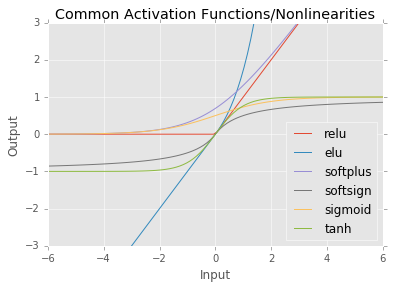

In [7]:
xs = np.linspace(-6, 6, 100)
plt.plot(xs, np.maximum(xs, 0), label = 'relu')
plt.plot(xs, [np.exp(x) - 1 if x >= 0 else x for x in xs], label = 'elu')
plt.plot(xs, np.log(np.exp(xs) + 1), label = 'softplus')
plt.plot(xs, xs / (abs(xs) + 1), label = 'softsign')
plt.plot(xs, 1 / (1 + np.exp(-xs)), label = 'sigmoid')
plt.plot(xs, np.tanh(xs), label = 'tanh')
plt.xlabel('Input')
plt.xlim([-6, 6])
plt.ylabel('Output')
plt.ylim([-3, 3])
plt.title('Common Activation Functions/Nonlinearities')
plt.legend(loc='lower right')

Remember, having series of linear followed by nonlinear operations is what makes neural networks expressive.  By stacking a lot of "linear" + "nonlinear" operations in a series, we can create a deep neural network!  Have a look at the output ranges of the above nonlinearity when considering which nonlinearity seems most appropriate.  For instance, the `relu` is always above 0, but does not saturate at any value above 0, meaning it can be anything above 0.  That's unlike the `sigmoid` which does saturate at both 0 and 1, meaning its values for a single output neuron will always be between 0 and 1.  Similarly, the `tanh` saturates at -1 and 1.

Choosing between these is often a matter of trial and error.  Though you can make some insights depending on your normalization scheme.  For instance, if your output is expected to be in the range of 0 to 1, you may not want to use a `tanh` function, which ranges from -1 to 1, but likely would want to use a `sigmoid`.  Keep the ranges of these activation functions in mind when designing your network, especially the final output layer of your network.

<a name="code"></a>
## Code

In this section, we're going to work out how to represent a fully connected neural network with code.  First, create a 2D `tf.placeholder` called $\textbf{X}$ with `None` for the batch size and 2 features.  Make its `dtype` `tf.float32`.  Recall that we use the dimension of `None` for the batch size dimension to say that this dimension can be any number.  Here is the docstring for the `tf.placeholder` function, have a look at what args it takes:

Help on function placeholder in module `tensorflow.python.ops.array_ops`:

```python
placeholder(dtype, shape=None, name=None)
```

    Inserts a placeholder for a tensor that will be always fed.

    **Important**: This tensor will produce an error if evaluated. Its value must
    be fed using the `feed_dict` optional argument to `Session.run()`,
    `Tensor.eval()`, or `Operation.run()`.

    For example:

```python
x = tf.placeholder(tf.float32, shape=(1024, 1024))
y = tf.matmul(x, x)

with tf.Session() as sess:
  print(sess.run(y))  # ERROR: will fail because x was not fed.

  rand_array = np.random.rand(1024, 1024)
  print(sess.run(y, feed_dict={x: rand_array}))  # Will succeed.
```

    Args:
      dtype: The type of elements in the tensor to be fed.
      shape: The shape of the tensor to be fed (optional). If the shape is not
        specified, you can feed a tensor of any shape.
      name: A name for the operation (optional).

    Returns:
      A `Tensor` that may be used as a handle for feeding a value, but not
      evaluated directly.

In [4]:
# Create a placeholder with None x 2 dimensions of dtype tf.float32, and name it "X":
X = tf.placeholder(tf.float32, shape = (None, 2), name = "X")

Now multiply the tensor using a new variable, $\textbf{W}$, which has 2 rows and 20 columns, so that when it is left mutiplied by $\textbf{X}$, the output of the multiplication is None x 20, giving you 20 output neurons.  Look up the docstrings of functions `tf.get_variable` and `tf.random_normal_initializer` to get familiar with these functions.  There are many options we will ignore for now.  Just be sure to set the `name`, `shape`, `dtype`, and `initializer` when creating your $\textbf{W}$ variable with `tf.get_variable(...)`. For the random normal initializer, often the mean is set to 0, and the standard deviation is set based on the number of neurons.  But that really depends on the input and outputs of your network, how you've "normalized" your dataset, what your nonlinearity/activation function is, and what your expected range of inputs/outputs are.  Don't worry about the values for the initializer for now, as this part will take a bit more experimentation to understand better!


In [5]:
W = tf.get_variable("W", shape = [2, 20], dtype = tf.float32, initializer = tf.random_normal_initializer())
h = tf.matmul(X, W)

And add to this result another new variable, $\textbf{b}$, which has [20] dimensions.  These values will be added to every output neuron after the multiplication above.  Instead of the `tf.random_normal_initializer` that you used for creating $\textbf{W}$, now use the `tf.constant_initializer`.  Often for bias, you'll set the constant bias initialization to 0 or 1.


In [6]:
b = tf.get_variable("b", shape = [20], dtype = tf.float32, initializer = tf.constant_initializer())
h = tf.nn.bias_add(h, b)

So far we have done:
$$\textbf{X}\textbf{W} + \textbf{b}$$

Finally, apply a nonlinear activation to this output, such as  `tf.nn.relu`, to complete the equation:

$$\textbf{H} = \phi(\textbf{X}\textbf{W} + \textbf{b})$$


In [7]:
h = tf.nn.relu(h)

Now that we've done all of this work, let's stick it inside a function.  I've already done this for you and placed it inside the `utils` module under the function name `linear`.  We've already imported the `utils` module so we can call it like so, `utils.linear(...)`.  The docstring is copied below, and the code itself.  Note that this function is slightly different to the one in the lecture.  It does not require you to specify `n_input`, and the input `scope` is called `name`.  It also has a few more extras in there including automatically converting a 4-d input tensor to a 2-d tensor so that you can fully connect the layer with a matrix multiply (don't worry about what this means if it doesn't make sense!).

```python
utils.linear??
```

```python
def linear(x, n_output, name=None, activation=None, reuse=None):
    """Fully connected layer

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        Scope to apply

    Returns
    -------
    op : tf.Tensor
        Output of fully connected layer.
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W
```

<a name="variable-scopes"></a>
## Variable Scopes

Note that since we are using `variable_scope` and explicitly telling the scope which name we would like, if there is *already* a variable created with the same name, then Tensorflow will raise an exception!  If this happens, you should consider one of three possible solutions:

1. If this happens while you are interactively editing a graph, you may need to reset the current graph:
```python
    tf.reset_default_graph()
```
You should really only have to use this if you are in an interactive console!  If you are creating Python scripts to run via command line, you should really be using solution 3 listed below, and be explicit with your graph contexts! 
2. If this happens and you were not expecting any name conflicts, then perhaps you had a typo and created another layer with the same name!  That's a good reason to keep useful names for everything in your graph!
3. More likely, you should be using context managers when creating your graphs and running sessions.  This works like so:

    ```python
    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        Y_pred, W = linear(X, 2, 3, activation=tf.nn.relu)
    ```

    or:

    ```python
    g = tf.Graph()
    with tf.Session(graph=g) as sess, g.as_default():
        Y_pred, W = linear(X, 2, 3, activation=tf.nn.relu)
    ```

You can now write the same process as the above steps by simply calling:

In [8]:
h, W = utils.linear(
    x=X, n_output=20, name='linear', activation=tf.nn.relu)

<a name="part-two---image-painting-network"></a>
# Part Two - Image Painting Network

<a name="instructions-1"></a>
## Instructions

Follow along the steps below, first setting up input and output data of the network, $\textbf{X}$ and $\textbf{Y}$. Then work through building the neural network which will try to compress the information in $\textbf{X}$ through a series of linear and non-linear functions so that whatever it is given as input, it minimized the error of its prediction, $\hat{\textbf{Y}}$, and the true output $\textbf{Y}$ through its training process.  You'll also create an animated GIF of the training which you'll need to submit for the homework!

Through this, we'll explore our first creative application: painting an image.  This network is just meant to demonstrate how easily networks can be scaled to more complicated tasks without much modification.  It is also meant to get you thinking about neural networks as building blocks that can be reconfigured, replaced, reorganized, and get you thinking about how the inputs and outputs can be anything you can imagine.

<a name="preparing-the-data"></a>
## Preparing the Data

We'll follow an example that Andrej Karpathy has done in his online demonstration of "image inpainting".  What we're going to do is teach the network to go from the location on an image frame to a particular color.  So given any position in an image, the network will need to learn what color to paint.  Let's first get an image that we'll try to teach a neural network to paint.


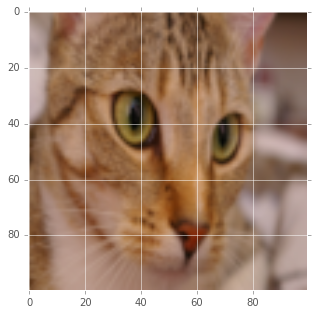

In [5]:
# First load an image
img = data.chelsea()

# Be careful with the size of your image.
# Try a fairly small image to begin with,
# then come back here and try larger sizes.
img = imresize(img, (100, 100))
plt.figure(figsize=(5, 5))
plt.imshow(img)

# Make sure you save this image as "reference.png"
# and include it in your zipped submission file
# so we can tell what image you are trying to paint!
plt.imsave(fname='reference.png', arr=img)

In the lecture, I showed how to aggregate the pixel locations and their colors using a loop over every pixel position.  I put that code into a function `split_image` below.  Feel free to experiment with other features for `xs` or `ys`.

In [3]:
def split_image(img):
    # We'll first collect all the positions in the image in our list, xs
    xs = []

    # And the corresponding colors for each of these positions
    ys = []

    # Now loop over the image
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            # And store the inputs
            xs.append([row_i, col_i])
            # And outputs that the network needs to learn to predict
            ys.append(img[row_i, col_i])

    # we'll convert our lists to arrays
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

Let's use this function to create the inputs (xs) and outputs (ys) to our network as the pixel locations (xs) and their colors (ys):

In [10]:
xs, ys = split_image(img)

# and print the shapes
print(img.shape)
#print(img)
print(xs.shape)
print(xs)
print(ys.shape)
print(ys)

(100, 100, 3)
(10000, 2)
[[ 0  0]
 [ 0  1]
 [ 0  2]
 ..., 
 [99 97]
 [99 98]
 [99 99]]
(10000, 3)
[[144 121 106]
 [143 120 104]
 [146 123 106]
 ..., 
 [173 150 144]
 [168 144 138]
 [167 142 134]]


Also remember, we should normalize our input values!

In [11]:
# Normalize the input (xs) using its mean and standard deviation
xs = (xs - np.mean(xs)) / np.std(xs)

# Just to make sure you have normalized it correctly:
print(np.min(xs), np.max(xs))
assert(np.min(xs) > -3.0 and np.max(xs) < 3.0)

-1.71481604244 1.71481604244


Similarly for the output:

In [12]:
print(np.min(ys), np.max(ys))

4 207


We'll normalize the output using a simpler normalization method, since we know the values range from 0-255:

In [13]:
ys = ys / 255.0
print(np.min(ys), np.max(ys))

0.0156862745098 0.811764705882


Scaling the image values like this has the advantage that it is still interpretable as an image, unlike if we have negative values.

What we're going to do is use regression to predict the value of a pixel given its (row, col) position.  So the input to our network is `X = (row, col)` value.  And the output of the network is `Y = (r, g, b)`.

We can get our original image back by reshaping the colors back into the original image shape.  This works because the `ys` are still in order:

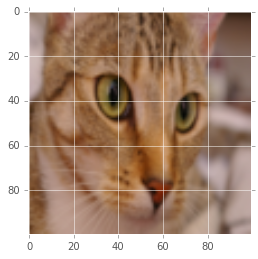

In [14]:
plt.imshow(ys.reshape(img.shape))

But when we give inputs of (row, col) to our network, it won't know what order they are, because we will randomize them.  So it will have to *learn* what color value should be output for any given (row, col).

Create 2 placeholders of `dtype` `tf.float32`: one for the input of the network, a `None x 2` dimension placeholder called $\textbf{X}$, and another for the true output of the network, a `None x 3` dimension placeholder called $\textbf{Y}$.


In [78]:
# Let's reset the graph:
tf.reset_default_graph()

# Create a placeholder of None x 2 dimensions and dtype tf.float32
# This will be the input to the network which takes the row/col
X = tf.placeholder(dtype = tf.float32, shape = [None, 2], name = "X")

# Create the placeholder, Y, with 3 output dimensions instead of 2.
# This will be the output of the network, the R, G, B values.
Y = tf.placeholder(dtype = tf.float32, shape = [None, 3], name = "Y")

Now create a deep neural network that takes your network input $\textbf{X}$ of 2 neurons, multiplies it by a linear and non-linear transformation which makes its shape [None, 20], meaning it will have 20 output neurons.  Then repeat the same process again to give you 20 neurons again, and then again and again until you've done 6 layers of 20 neurons.  Then finally one last layer which will output 3 neurons, your predicted output, which I've been denoting mathematically as $\hat{\textbf{Y}}$, for a total of 6 hidden layers, or 8 layers total including the input and output layers.  Mathematically, we'll be creating a deep neural network that looks just like the previous fully connected layer we've created, but with a few more connections. So recall the first layer's connection is:

\begin{align}
\textbf{H}_1=\phi(\textbf{X}\textbf{W}_1 + \textbf{b}_1) \\
\end{align}

So the next layer will take that output, and connect it up again:

\begin{align}
\textbf{H}_2=\phi(\textbf{H}_1\textbf{W}_2 + \textbf{b}_2) \\
\end{align}

And same for every other layer:

\begin{align}
\textbf{H}_3=\phi(\textbf{H}_2\textbf{W}_3 + \textbf{b}_3) \\
\textbf{H}_4=\phi(\textbf{H}_3\textbf{W}_4 + \textbf{b}_4) \\
\textbf{H}_5=\phi(\textbf{H}_4\textbf{W}_5 + \textbf{b}_5) \\
\textbf{H}_6=\phi(\textbf{H}_5\textbf{W}_6 + \textbf{b}_6) \\
\end{align}

Including the very last layer, which will be the prediction of the network:

\begin{align}
\hat{\textbf{Y}}=\phi(\textbf{H}_6\textbf{W}_7 + \textbf{b}_7)
\end{align}

Remember if you run into issues with variable scopes/names, that you cannot recreate a variable with the same name! Revisit the section on <a href='#Variable-Scopes'>Variable Scopes</a> if you get stuck with name issues.


In [79]:
# We'll create 6 hidden layers.  Let's create a variable
# to say how many neurons we want for each of the layers
# (try 20 to begin with, then explore other values)
#n_neurons = 20

# Create the first linear + nonlinear layer which will
# take the 2 input neurons and fully connects it to 20 neurons.
# Use the `utils.linear` function to do this just like before,
# but also remember to give names for each layer, such as
# "1", "2", ... "5", or "layer1", "layer2", ... "layer6".

#h1, W1 = utils.linear(X, n_neurons, activation = tf.nn.relu, name = "layer_1")
#h2, W2 = utils.linear(h1, n_neurons, activation = tf.nn.relu, name = "layer_2")
#h3, W3 = utils.linear(h2, n_neurons, activation = tf.nn.relu, name = "layer_3")
#h4, W4 = utils.linear(h3, n_neurons, activation = tf.nn.relu, name = "layer_4")
#h5, W5 = utils.linear(h4, n_neurons, activation = tf.nn.relu, name = "layer_5")
#h6, W6 = utils.linear(h5, n_neurons, activation = tf.nn.relu, name = "layer_6")
#Y_pred, W7 = utils.linear(h6, 3, activation=None, name='pred')

# number of neurons in each layer
n_neurons = [30] * 8 + [3]
# activation functions
act_f = [tf.nn.relu, tf.nn.elu, tf.nn.softplus, tf.nn.softsign, tf.sigmoid, tf.tanh][2]

current_input = X
for layer_i in range(len(n_neurons)):
    current_input, Wn = utils.linear(
            x = current_input, 
            n_output = n_neurons[layer_i],
            activation = act_f if (layer_i + 1) < len(n_neurons) else None,
            name = 'layer_' + str(layer_i))
Y_pred = current_input
print(Y_pred)

Tensor("layer_8/h:0", shape=(?, 3), dtype=float32)


In [80]:
assert(X.get_shape().as_list() == [None, 2])
assert(Y_pred.get_shape().as_list() == [None, 3])
assert(Y.get_shape().as_list() == [None, 3])

<a name="cost-function"></a>
## Cost Function

Now we're going to work on creating a `cost` function.  The cost should represent how much `error` there is in the network, and provide the optimizer this value to help it train the network's parameters using gradient descent and backpropagation.

Let's say our error is `E`, then the cost will be:

$$cost(\textbf{Y}, \hat{\textbf{Y}}) = \frac{1}{\text{B}} \displaystyle\sum\limits_{b=0}^{\text{B}} \textbf{E}_b
$$

where the error is measured as, e.g.:

$$\textbf{E} = \displaystyle\sum\limits_{c=0}^{\text{C}} (\textbf{Y}_{c} - \hat{\textbf{Y}}_{c})^2$$

Don't worry if this scares you.  This is mathematically expressing the same concept as: "the cost of an actual $\textbf{Y}$, and a predicted $\hat{\textbf{Y}}$ is equal to the mean across batches, of which there are $\text{B}$ total batches, of the sum of distances across $\text{C}$ color channels of every predicted output and true output".  Basically, we're trying to see on average, or at least within a single minibatches average, how wrong was our prediction?  We create a measure of error for every output feature by squaring the predicted output and the actual output it should have, i.e. the actual color value it should have output for a given input pixel position.  By squaring it, we penalize large distances, but not so much small distances.

Consider how the square function (i.e., $f(x) = x^2$) changes for a given error.  If our color values range between 0-255, then a typical amount of error would be between $0$ and $128^2$.  For example if my prediction was (120, 50, 167), and the color should have been (0, 100, 120), then the error for the Red channel is (120 - 0) or 120.  And the Green channel is (50 - 100) or -50, and for the Blue channel, (167 - 120) = 47.  When I square this result, I get: (120)^2, (-50)^2, and (47)^2.  I then add all of these and that is my error, $\textbf{E}$, for this one observation.  But I will have a few observations per minibatch.  So I add all the error in my batch together, then divide by the number of observations in the batch, essentially finding the mean error of my batch.  

Let's try to see what the square in our measure of error is doing graphically.

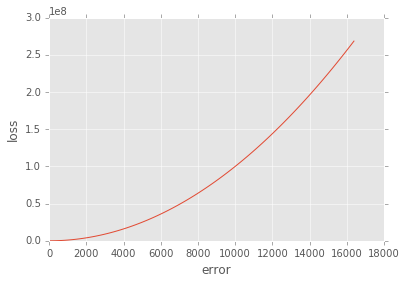

In [81]:
error = np.linspace(0.0, 128.0**2, 100)
loss = error**2.0
plt.plot(error, loss)
plt.xlabel('error')
plt.ylabel('loss')

This is known as the $l_2$ (pronounced el-two) loss.  It doesn't penalize small errors as much as it does large errors.  This is easier to see when we compare it with another common loss, the $l_1$ (el-one) loss.  It is linear in error, by taking the absolute value of the error.  We'll compare the $l_1$ loss with normalized values from $0$ to $1$.  So instead of having $0$ to $255$ for our RGB values, we'd have $0$ to $1$, simply by dividing our color values by $255.0$.

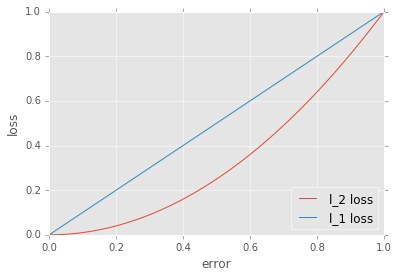

In [82]:
error = np.linspace(0.0, 1.0, 100)
plt.plot(error, error**2, label='l_2 loss')
plt.plot(error, np.abs(error), label='l_1 loss')
plt.xlabel('error')
plt.ylabel('loss')
plt.legend(loc='lower right')

So unlike the $l_2$ loss, the $l_1$ loss is really quickly upset if there is *any* error at all: as soon as error moves away from $0.0$, to $0.1$, the $l_1$ loss is $0.1$.  But the $l_2$ loss is $0.1^2 = 0.01$.  Having a stronger penalty on smaller errors often leads to what the literature calls "sparse" solutions, since it favors activations that try to explain as much of the data as possible, rather than a lot of activations that do a sort of good job,  but when put together, do a great job of explaining the data.  Don't worry about what this means if you are more unfamiliar with Machine Learning.  There is a lot of literature surrounding each of these loss functions that we won't have time to get into, but look them up if they interest you.

During the lecture, we've seen how to create a cost function using Tensorflow.  To create a $l_2$ loss function, you can for instance use tensorflow's `tf.squared_difference` or for an $l_1$ loss function, `tf.abs`.  You'll need to refer to the `Y` and `Y_pred` variables only, and your resulting cost should be a single value.  Try creating the $l_1$ loss to begin with, and come back here after you have trained your network, to compare the performance with a $l_2$ loss.

The equation for computing cost I mentioned above is more succintly written as, for $l_2$ norm:

$$cost(\textbf{Y}, \hat{\textbf{Y}}) = \frac{1}{\text{B}} \displaystyle\sum\limits_{b=0}^{\text{B}} \displaystyle\sum\limits_{c=0}^{\text{C}} (\textbf{Y}_{c} - \hat{\textbf{Y}}_{c})^2$$

For $l_1$ norm, we'd have:

$$cost(\textbf{Y}, \hat{\textbf{Y}}) = \frac{1}{\text{B}} \displaystyle\sum\limits_{b=0}^{\text{B}} \displaystyle\sum\limits_{c=0}^{\text{C}} \text{abs}(\textbf{Y}_{c} - \hat{\textbf{Y}}_{c})$$

Remember, to understand this equation, try to say it out loud: the $cost$ given two variables, $\textbf{Y}$, the actual output we want the network to have, and $\hat{\textbf{Y}}$ the predicted output from the network, is equal to the mean across $\text{B}$ batches, of the sum of $\textbf{C}$ color channels distance between the actual and predicted outputs.  If you're still unsure, refer to the lecture where I've computed this, or scroll down a bit to where I've included the answer.


In [83]:
# first compute the error, the inner part of the summation.
# This should be the l1-norm or l2-norm of the distance
# between each color channel.
error = tf.squared_difference(Y, Y_pred)
assert(error.get_shape().as_list() == [None, 3])

In [84]:
# Now sum the error for each feature in Y. 
# If Y is [Batch, Features], the sum should be [Batch]:
sum_error = tf.reduce_sum(error, 1)
assert(sum_error.get_shape().as_list() == [None])

In [85]:
# Finally, compute the cost, as the mean error of the batch.
# This should be a single value.
cost = tf.reduce_sum(error)
assert(cost.get_shape().as_list() == [])

We now need an `optimizer` which will take our `cost` and a `learning_rate`, which says how far along the gradient to move.  This optimizer calculates all the gradients in our network with respect to the `cost` variable and updates all of the weights in our network using backpropagation.  We'll then create mini-batches of our training data and run the `optimizer` using a `session`.


In [86]:
# Refer to the help for the function
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Create parameters for the number of iterations to run for (< 100)
n_iterations = 700

# And how much data is in each minibatch (< 500)
batch_size = 200

# Then create a session
sess = tf.Session()

We'll now train our network!  The code below should do this for you if you've setup everything else properly.  Please read through this and make sure you understand each step!  Note that this can take a VERY LONG time depending on the size of your image (make it < 100 x 100 pixels), the number of neurons per layer (e.g. < 30), the number of layers (e.g. < 8), and number of iterations (< 1000).  Welcome to Deep Learning :)

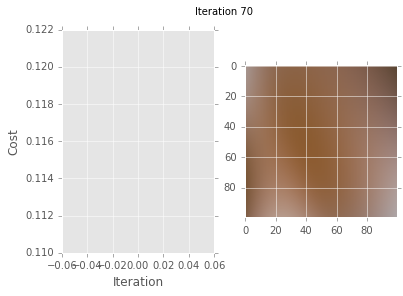

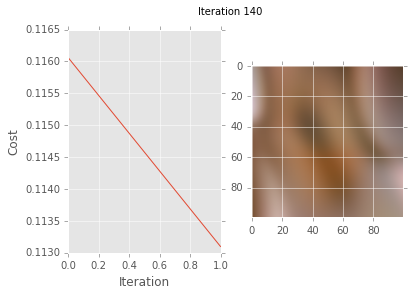

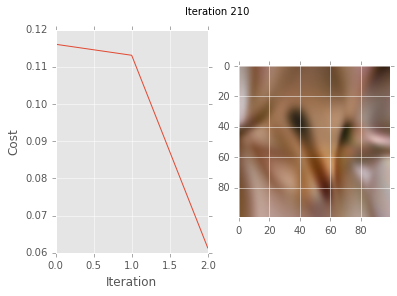

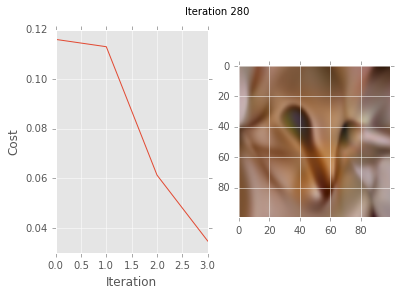

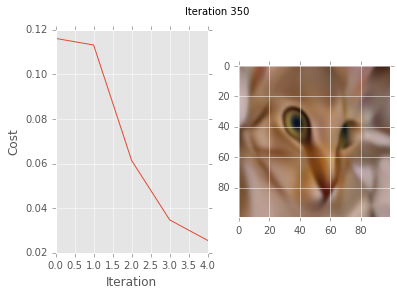

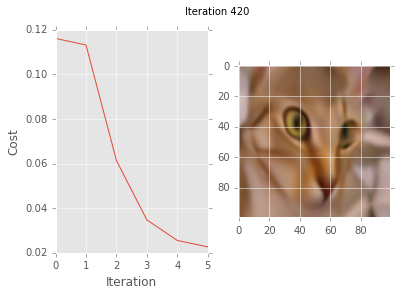

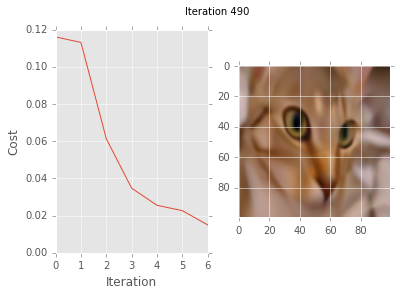

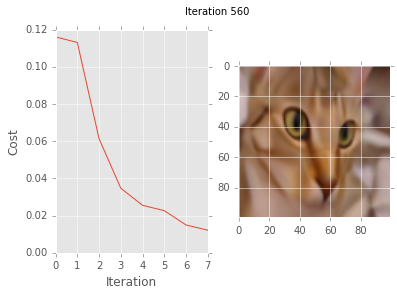

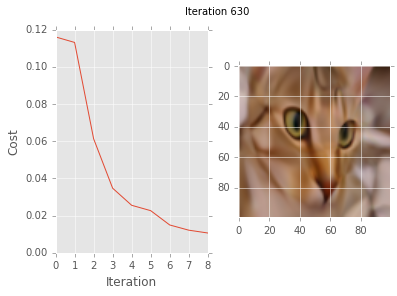

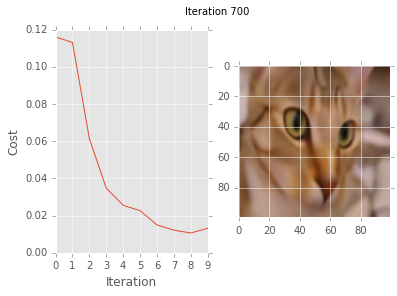

In [87]:
# Initialize all your variables and run the operation with your session
sess.run(tf.initialize_all_variables())

# Optimize over a few iterations, each time following the gradient
# a little at a time
imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

for it_i in range(n_iterations):
    
    # Get a random sampling of the dataset
    idxs = np.random.permutation(range(len(xs)))
    
    # The number of batches we have to iterate over
    n_batches = len(idxs) // batch_size
    
    # Now iterate over our stochastic minibatches:
    for batch_i in range(n_batches):
         
        # Get just minibatch amount of data
        idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]

        # And optimize, also returning the cost so we can monitor
        # how our optimization is doing.
        training_cost = sess.run(
            [cost, optimizer],
            feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]

    # Also, every 20 iterations, we'll draw the prediction of our
    # input xs, which should try to recreate our image!
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        # Plot the cost over time
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i + 1))
        plt.show()

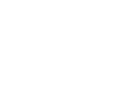

In [88]:
# Save the images as a GIF
_ = gif.build_gif(imgs, saveto='single.gif', show_gif=False)

Let's now display the GIF we've just created:

In [90]:
ipyd.Image(url='single.gif?{}'.format(np.random.rand()),
           height=250, width=250)

<a name="explore"></a>
## Explore

Go back over the previous cells and exploring changing different parameters of the network.  I would suggest first trying to change the `learning_rate` parameter to different values and see how the cost curve changes.  What do you notice?  Try exponents of $10$, e.g. $10^1$, $10^2$, $10^3$... and so on.  Also try changing the `batch_size`: $50, 100, 200, 500, ...$ How does it effect how the cost changes over time?

Be sure to explore other manipulations of the network, such as changing the loss function to $l_2$ or $l_1$.  How does it change the resulting learning?  Also try changing the activation functions, the number of layers/neurons, different optimizers, and anything else that you may think of, and try to get a basic understanding on this toy problem of how it effects the network's training.  Also try comparing creating a fairly shallow/wide net (e.g. 1-2 layers with many neurons, e.g. > 100), versus a deep/narrow net (e.g. 6-20 layers with fewer neurons, e.g. < 20).  What do you notice?

<a name="a-note-on-crossvalidation"></a>
## A Note on Crossvalidation

The cost curve plotted above is only showing the cost for our "training" dataset.  Ideally, we should split our dataset into what are called "train", "validation", and "test" sets.  This is done by taking random subsets of the entire dataset.  For instance, we partition our dataset by saying we'll only use 80% of it for training, 10% for validation, and the last 10% for testing.  Then when training as above, you would only use the 80% of the data you had partitioned, and then monitor accuracy on both the data you have used to train, but also that new 10% of unseen validation data.  This gives you a sense of how "general" your network is.  If it is performing just as well on that 10% of data, then you know it is doing a good job.  Finally, once you are done training, you would test one last time on your "test" dataset.  Ideally, you'd do this a number of times, so that every part of the dataset had a chance to be the test set.  This would also give you a measure of the variance of the accuracy on the final test.  If it changes a lot, you know something is wrong.  If it remains fairly stable, then you know that it is a good representation of the model's accuracy on unseen data.

We didn't get a chance to cover this in class, as it is less useful for exploring creative applications, though it is very useful to know and to use in practice, as it avoids overfitting/overgeneralizing your network to all of the data.  Feel free to explore how to do this on the application above!

<a name="part-three---learning-more-than-one-image"></a>
# Part Three - Learning More than One Image

<a name="instructions-2"></a>
## Instructions

We're now going to make use of our Dataset from Session 1 and apply what we've just learned to try and paint every single image in our dataset.  How would you guess is the best way to approach this?  We could for instance feed in every possible image by having multiple row, col -> r, g, b values.  So for any given row, col, we'd have 100 possible r, g, b values.  This likely won't work very well as there are many possible values a pixel could take, not just one.  What if we also tell the network *which* image's row and column we wanted painted?  We're going to try and see how that does.

You can execute all of the cells below unchanged to see how this works with the first 100 images of the celeb dataset.  But you should replace the images with your own dataset, and vary the parameters of the network to get the best results!

I've placed the same code for running the previous algorithm into two functions, `build_model` and `train`.  You can directly call the function `train` with a 4-d image shaped as N x H x W x C, and it will collect all of the points of every image and try to predict the output colors of those pixels, just like before.  The only difference now is that you are able to try this with a few images at a time.  There are a few ways we could have tried to handle multiple images.  The way I've shown in the `train` function is to include an additional input neuron for *which* image it is.  So as well as receiving the row and column, the network will also receive as input which image it is as a number.  This should help the network to better distinguish the patterns it uses, as it has knowledge that helps it separates its process based on which image is fed as input.

In [4]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn,
                final_activation_fn, cost_type):
    
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xs.ndim != 2:
        raise ValueError(
            'xs should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
    if ys.ndim != 2:
        raise ValueError(
            'ys should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
        
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs],
                       dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys],
                       dtype=tf.float32)

    current_input = X
    for layer_i in range(n_layers):
        current_input = utils.linear(
            current_input, n_neurons,
            activation=activation_fn,
            name='layer{}'.format(layer_i))[0]

    Y_pred = utils.linear(
        current_input, n_ys,
        activation=final_activation_fn,
        name='pred')[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError(
            'Unknown cost_type: {}.  '.format(
            cost_type) + 'Use only "l1_norm" or "l2_norm"')
    
    return {'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost}

In [5]:
def train(imgs,
          learning_rate=0.0001,
          batch_size=200,
          n_iterations=10,
          gif_step=2,
          n_neurons=30,
          n_layers=10,
          activation_fn=tf.nn.relu,
          final_activation_fn=tf.nn.tanh,
          cost_type='l2_norm'):

    #N, H, W, C = imgs.shape
    #print("dimention of imgs: {}".format(imgs.shape))
    
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    
    #print("length of all_xs: {}".format(len(all_xs)))
    #print("dimention of x: {}".format(all_xs[0].shape))
    #print("length of all_ys: {}".format(len(all_ys)))
    #print("dimention of y: {}".format(all_ys[0].shape))
    
    xs = np.array(all_xs).reshape(-1, 3)
    xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    #print("demention of xs reshaped: {}".format(xs.shape))
    
    ys = np.array(all_ys).reshape(-1, 3)
    ys = ys / 127.5 - 1
    #print("demention of ys reshaped: {}".format(ys.shape))

    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers,
                            activation_fn, final_activation_fn,
                            cost_type)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model['cost'])
        sess.run(tf.initialize_all_variables())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            # Get a random sampling of the dataset
            idxs = np.random.permutation(range(len(xs)))
            
            # The number of batches we have to iterate over
            n_batches = len(idxs) // batch_size
            training_cost = 0

            # Now iterate over our stochastic minibatches:
            for batch_i in range(n_batches):

                # Get just minibatch amount of data
                idxs_i = idxs[batch_i * batch_size:
                              (batch_i + 1) * batch_size]

                # And optimize, also returning the cost so we can monitor
                # how our optimization is doing.
                cost = sess.run(
                    [model['cost'], optimizer],
                    feed_dict = {model['X']: xs[idxs_i],
                                 model['Y']: ys[idxs_i]})[0]
                training_cost += cost

            print('iteration {}/{}: cost {}'.format(
                    it_i + 1, n_iterations, training_cost / n_batches))

            # Also, every 20 iterations, we'll draw the prediction of our
            # input xs, which should try to recreate our image!
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(
                    feed_dict={model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
        return gifs

<a name="code-1"></a>
## Code

Below, I've shown code for loading the first 100 celeb files.  Run through the next few cells to see how this works with the celeb dataset, and then come back here and replace the `imgs` variable with your own set of images.  For instance, you can try your entire sorted dataset from Session 1 as an N x H x W x C array.  Explore!


In [6]:
def crop_edge(img, cropped_rate):
    """Crop arbitrary amount of pixel.
    """
    row_i = int(img.shape[0] * cropped_rate) // 2
    col_i = int(img.shape[1] * cropped_rate) // 2
    return img[row_i:-row_i, col_i:-col_i]

Number of files: 100
Length of bush_imgs: 100
Dimention of one image: (100, 100, 3)
Dimention of bush_imgs (final): (100, 100, 100, 3)


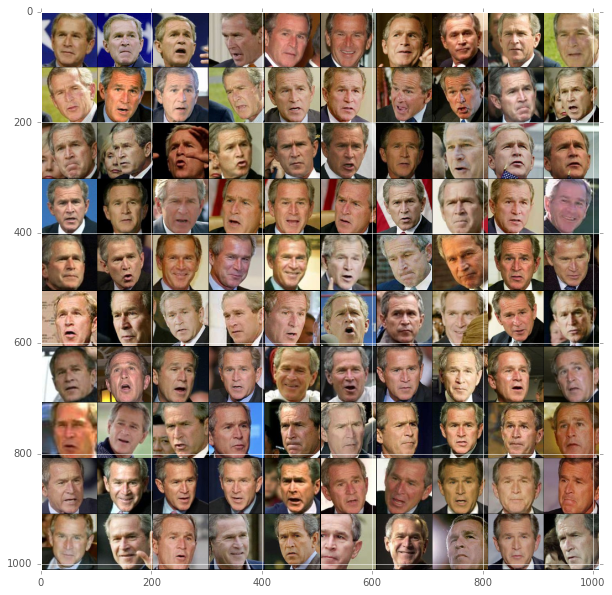

In [7]:
#celeb_imgs = utils.get_celeb_imgs()
#plt.figure(figsize=(10, 10))
#plt.imshow(utils.montage(celeb_imgs).astype(np.uint8))

# get a set of Bush image file paths as a list
bush_files = [os.path.join('../session-1/George_W_Bush', file_i)
              for file_i in os.listdir('../session-1/George_W_Bush')
              if '.jpg' in file_i]
print("Number of files: {}".format(len(bush_files)))

# load images with cropping and resizing
bush_imgs = [imresize(crop_edge(plt.imread(f), 0.4), (100, 100)) for f in bush_files]
print("Length of bush_imgs: {}".format(len(bush_imgs)))
print("Dimention of one image: {}".format(bush_imgs[0].shape))

# In case there is any IOError during load
#bush_imgs = []
#try:
#    for f in bush_files:
#        bush_imgs.append(plt.imread(f))
#        
#except IOError:
#    pass

# plot images
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(bush_imgs).astype(np.uint8))

# create input array for training
bush_imgs = np.array(bush_imgs)
print("Dimention of bush_imgs (final): {}".format(bush_imgs.shape))

Explore changing the parameters of the `train` function and your own dataset of images.  Note, you do not have to use the dataset from the last assignment!  Explore different numbers of images, whatever you prefer.


In [8]:
# Change the parameters of the train function and
# explore changing the dataset
gifs = train(bush_imgs, 
             learning_rate = [0.0001, 0.001, 0.01][1],
             batch_size = [100, 200, 400, 800, 1600][2],
             n_iterations = [10, 20, 30, 50, 100][3],
             gif_step = 2,
             n_neurons = [10, 20, 30, 40, 50][2],
             n_layers = [6, 8, 10, 12, 15][2],
             activation_fn = [tf.nn.relu, tf.nn.elu, tf.nn.softplus, 
                              tf.nn.softsign, tf.sigmoid, tf.tanh][2],
             final_activation_fn = None,
             cost_type = ['l1_norm', 'l2_norm'][0])

dimention of imgs: (100, 100, 100, 3)
length of all_xs: 100
dimention of x: (10000, 3)
length of all_ys: 100
dimention of y: (10000, 3)
demention of xs reshaped: (1000000, 3)
demention of ys reshaped: (1000000, 3)
iteration 1/50: cost 1.0200877800703048
iteration 2/50: cost 0.9673902454137802
iteration 3/50: cost 0.9556875091314316
iteration 4/50: cost 0.9520055309295654
iteration 5/50: cost 0.9496414321899415
iteration 6/50: cost 0.947131126666069
iteration 7/50: cost 0.9422373376607895
iteration 8/50: cost 0.9313999535560608
iteration 9/50: cost 0.9198409189462662
iteration 10/50: cost 0.9080090027809143
iteration 11/50: cost 0.897014000916481
iteration 12/50: cost 0.8865073990106582
iteration 13/50: cost 0.8767544286489487
iteration 14/50: cost 0.8658700793504714
iteration 15/50: cost 0.8584650648593902
iteration 16/50: cost 0.8514250570297242
iteration 17/50: cost 0.842766197514534
iteration 18/50: cost 0.8349967066049576
iteration 19/50: cost 0.8267794742584228
iteration 20/50: co

Now we'll create a gif out of the training process.  Be sure to call this 'multiple.gif' for your homework submission:

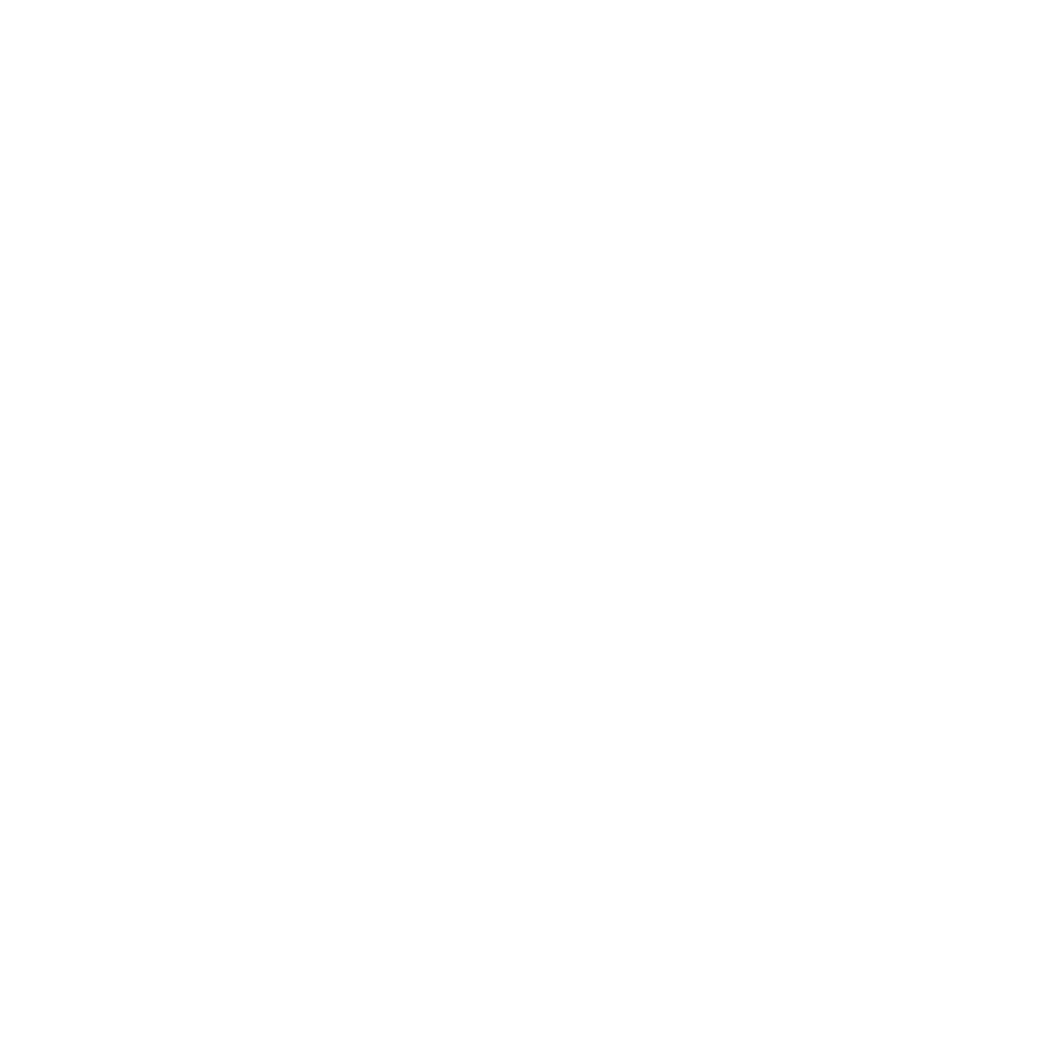

In [9]:
montage_gifs = [np.clip(utils.montage((m * 127.5) + 127.5), 0, 255).astype(np.uint8)
                for m in gifs]
_ = gif.build_gif(montage_gifs, saveto='multiple.gif')

And show it in the notebook

In [13]:
ipyd.Image(url='multiple.gif?{}'.format(np.random.rand()), height=500, width=500)


What we're seeing is the training process over time.  We feed in our `xs`, which consist of the pixel values of each of our 100 images, it goes through the neural network, and out come predicted color values for every possible input value.  We visualize it above as a gif by seeing how at each iteration the network has predicted the entire space of the inputs.  We can visualize just the last iteration as a "latent" space, going from the first image (the top left image in the montage), to the last image, (the bottom right image).

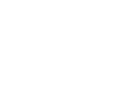

In [11]:
final = gifs[-1]
final_gif = [np.clip(((m * 127.5) + 127.5), 0, 255).astype(np.uint8) for m in final]
gif.build_gif(final_gif, saveto='final.gif')

In [12]:
ipyd.Image(url='final.gif?{}'.format(np.random.rand()), height=200, width=200)

<a name="part-four---open-exploration-extra-credit"></a>
# Part Four - Open Exploration (Extra Credit)

I now what you to explore what other possible manipulations of the network and/or dataset you could imagine.  Perhaps a process that does the reverse, tries to guess where a given color should be painted?  What if it was only taught a certain palette, and had to reason about other colors, how it would interpret those colors?  Or what if you fed it pixel locations that weren't part of the training set, or outside the frame of what it was trained on?  Or what happens with different activation functions, number of layers, increasing number of neurons or lesser number of neurons?  I leave any of these as an open exploration for you.

Try exploring this process with your own ideas, materials, and networks, and submit something you've created as a gif!   To aid exploration, be sure to scale the image down quite a bit or it will require a much larger machine, and much more time to train.  Then whenever you think you may be happy with the process you've created, try scaling up the resolution and leave the training to happen over a few hours/overnight to produce something truly stunning!

Make sure to name the result of your gif: "explore.gif", and be sure to include it in your zip file.

In [8]:
import gc

def grid_search(imgs,
                cost_type,
                learning_rate = [0.001],
                batch_size = [100, 200, 400],
                n_iterations = [15, 30, 60],
                n_neurons = [20, 30, 40],
                n_layers = [8, 12, 16],
                activation_fn = [tf.nn.elu, tf.nn.softsign]):
    """
    Execute train with a varaety of parameter combinations.
    """
    for lr in learning_rate:
        for bs in batch_size:
            for ni in n_iterations:
                for nn in n_neurons:
                    for nl in n_layers:
                        for af in activation_fn:
                            print("=======================================")
                            print("learning rate: {}\n".format(lr) +
                                  "batch size   : {}\n".format(bs) +
                                  "n_iterations : {}\n".format(ni) +
                                  "n_neurons    : {}\n".format(nn) +
                                  "n_layers     : {}\n".format(nl) +
                                  "activation_fn: {}\n".format(af.__name__))
                            try:
                                # run training
                                gifs = train(imgs, lr, bs, ni, ni // 5, nn, nl, af, None, cost_type)
                                # reverse shape and values of final gif
                                final_gif = [np.clip(((g * 127.5) + 127.5), 0, 255).astype(np.uint8) for g in gifs[-1]]

                                # save in file
                                file_name = "{}_{}_{}_{}_{}_{}_{}.gif".format(cost_type,lr,bs,ni,nn,nl,af.__name__)
                                gif.build_gif(final_gif, saveto = file_name)
                                plt.close()

                                # show gif
                                ipyd.display(ipyd.Image(url = file_name, height = 125, width = 125))
                            except :
                                print("Oops... error occurred, maybe due to memory problem.")
                                
                            # clean up memory
                            gifs = None
                            final_gif = None
                            gc.collect()


In [9]:
grid_search(bush_imgs, "l1_norm")

learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 20
n_layers     : 8
activation_fn: elu

iteration 1/15: cost 0.9730673417329788
iteration 2/15: cost 0.9510599811851979
iteration 3/15: cost 0.9369984488129616
iteration 4/15: cost 0.9156996442437172
iteration 5/15: cost 0.8984127745687962
iteration 6/15: cost 0.8841936839282513
iteration 7/15: cost 0.8718844805300235
iteration 8/15: cost 0.8618965073585511
iteration 9/15: cost 0.8545241551816464
iteration 10/15: cost 0.8486017095863819
iteration 11/15: cost 0.8426064192473889
iteration 12/15: cost 0.8368710665225982
iteration 13/15: cost 0.8319545324206352
iteration 14/15: cost 0.8262981223344803
iteration 15/15: cost 0.821413534605503


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 20
n_layers     : 8
activation_fn: softsign

iteration 1/15: cost 0.9775085963964463
iteration 2/15: cost 0.9533432161152363
iteration 3/15: cost 0.9482355465292931
iteration 4/15: cost 0.9442661588430404
iteration 5/15: cost 0.938352901595831
iteration 6/15: cost 0.9310673448264599
iteration 7/15: cost 0.924886362272501
iteration 8/15: cost 0.9193055183053017
iteration 9/15: cost 0.9133914373517037
iteration 10/15: cost 0.9073022590637208
iteration 11/15: cost 0.9019418450295925
iteration 12/15: cost 0.8973418550312519
iteration 13/15: cost 0.8929448079705238
iteration 14/15: cost 0.888968206501007
iteration 15/15: cost 0.8851310992002487


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 20
n_layers     : 12
activation_fn: elu

iteration 1/15: cost 0.9701878592133522
iteration 2/15: cost 0.9419805478751659
iteration 3/15: cost 0.9250011552393437
iteration 4/15: cost 0.9073564435362815
iteration 5/15: cost 0.892611183899641
iteration 6/15: cost 0.8793629971563816
iteration 7/15: cost 0.8685488119244575
iteration 8/15: cost 0.8587742018342018
iteration 9/15: cost 0.850409923428297
iteration 10/15: cost 0.8432927099347115
iteration 11/15: cost 0.8362986265063286
iteration 12/15: cost 0.8302206305265427
iteration 13/15: cost 0.824154982471466
iteration 14/15: cost 0.8171164616346359
iteration 15/15: cost 0.8111037399530411


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 20
n_layers     : 12
activation_fn: softsign

iteration 1/15: cost 0.9776805848002433
iteration 2/15: cost 0.9558563221991062
iteration 3/15: cost 0.9494621670007706
iteration 4/15: cost 0.9423907091557979
iteration 5/15: cost 0.935794824308157
iteration 6/15: cost 0.9313412850558758
iteration 7/15: cost 0.9272022153615952
iteration 8/15: cost 0.9236357879400253
iteration 9/15: cost 0.9201071843743325
iteration 10/15: cost 0.9169182209908963
iteration 11/15: cost 0.9134375614702701
iteration 12/15: cost 0.9099447179496288
iteration 13/15: cost 0.9062997726261616
iteration 14/15: cost 0.902713416570425
iteration 15/15: cost 0.899226102733612


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 20
n_layers     : 16
activation_fn: elu

iteration 1/15: cost 0.9704292246103287
iteration 2/15: cost 0.9529381220817565
iteration 3/15: cost 0.9429462628781795
iteration 4/15: cost 0.9251667188405991
iteration 5/15: cost 0.909041528826952
iteration 6/15: cost 0.8889870061993599
iteration 7/15: cost 0.8758101329624652
iteration 8/15: cost 0.86404284735322
iteration 9/15: cost 0.8537332277417183
iteration 10/15: cost 0.8479806166946888
iteration 11/15: cost 0.8426821869909763
iteration 12/15: cost 0.8380733458161354
iteration 13/15: cost 0.8319247102081776
iteration 14/15: cost 0.8283240999400616
iteration 15/15: cost 0.8229726287543774


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 20
n_layers     : 16
activation_fn: softsign

iteration 1/15: cost 0.9812352849364281
iteration 2/15: cost 0.9577763977825642
iteration 3/15: cost 0.9505205502927303
iteration 4/15: cost 0.9445404027700424
iteration 5/15: cost 0.9394869872808457
iteration 6/15: cost 0.9413394352674485
iteration 7/15: cost 0.9361043487370014
iteration 8/15: cost 0.9282207791745662
iteration 9/15: cost 0.9222952844619751
iteration 10/15: cost 0.9173821565747261
iteration 11/15: cost 0.9140623077690602
iteration 12/15: cost 0.9100311766922474
iteration 13/15: cost 0.9067601543188095
iteration 14/15: cost 0.9035374953269959
iteration 15/15: cost 0.9017183120131492


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 30
n_layers     : 8
activation_fn: elu

iteration 1/15: cost 0.97163063519001
iteration 2/15: cost 0.948096353596449
iteration 3/15: cost 0.920321636736393
iteration 4/15: cost 0.8996177892029286
iteration 5/15: cost 0.8787215035200119
iteration 6/15: cost 0.859897180891037
iteration 7/15: cost 0.8426672675728798
iteration 8/15: cost 0.8277597829580307
iteration 9/15: cost 0.8133569056868554
iteration 10/15: cost 0.7992629043340683
iteration 11/15: cost 0.7859173410594463
iteration 12/15: cost 0.7737481652200222
iteration 13/15: cost 0.7602801547467709
iteration 14/15: cost 0.7473886450111866
iteration 15/15: cost 0.7364803114652634


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 30
n_layers     : 8
activation_fn: softsign

iteration 1/15: cost 0.9739644966304303
iteration 2/15: cost 0.9488162111580372
iteration 3/15: cost 0.9356894140064717
iteration 4/15: cost 0.9254406330525875
iteration 5/15: cost 0.9188931936979294
iteration 6/15: cost 0.912990481710434
iteration 7/15: cost 0.9072627462685108
iteration 8/15: cost 0.9015375783264638
iteration 9/15: cost 0.8946660934627056
iteration 10/15: cost 0.885879498898983
iteration 11/15: cost 0.8779174804270268
iteration 12/15: cost 0.8718573122680188
iteration 13/15: cost 0.8651467378377914
iteration 14/15: cost 0.8600324711620808
iteration 15/15: cost 0.8544494165897369


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 30
n_layers     : 12
activation_fn: elu

iteration 1/15: cost 0.9687248220086098
iteration 2/15: cost 0.9484442318022251
iteration 3/15: cost 0.9219479195475578
iteration 4/15: cost 0.9004340995132923
iteration 5/15: cost 0.8778017310619354
iteration 6/15: cost 0.857043507885933
iteration 7/15: cost 0.839798280018568
iteration 8/15: cost 0.8228773066043854
iteration 9/15: cost 0.8048764286160469
iteration 10/15: cost 0.7793972163319588
iteration 11/15: cost 0.7607767861902713
iteration 12/15: cost 0.7432598679125308
iteration 13/15: cost 0.7243008340090513
iteration 14/15: cost 0.7083257714658976
iteration 15/15: cost 0.690743798866868


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 30
n_layers     : 12
activation_fn: softsign

iteration 1/15: cost 0.9784417725741863
iteration 2/15: cost 0.9548286619007588
iteration 3/15: cost 0.944371210616827
iteration 4/15: cost 0.9361863551139832
iteration 5/15: cost 0.926789961206913
iteration 6/15: cost 0.9179549170196056
iteration 7/15: cost 0.9114708819866181
iteration 8/15: cost 0.9044110757410526
iteration 9/15: cost 0.8974055734992027
iteration 10/15: cost 0.8915493472516537
iteration 11/15: cost 0.8857478391945363
iteration 12/15: cost 0.8805026901125907
iteration 13/15: cost 0.875600131458044
iteration 14/15: cost 0.8709281921982766
iteration 15/15: cost 0.8665863576054573


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 30
n_layers     : 16
activation_fn: elu

iteration 1/15: cost 0.9712247319757938
iteration 2/15: cost 0.9489511107027531
iteration 3/15: cost 0.9224636475980282
iteration 4/15: cost 0.8989224144458771
iteration 5/15: cost 0.8776340491354465
iteration 6/15: cost 0.8573149001419544
iteration 7/15: cost 0.8419248067200183
iteration 8/15: cost 0.8304884880363941
iteration 9/15: cost 0.8271608040094376
iteration 10/15: cost 0.8136254900217056
iteration 11/15: cost 0.806671822398901
iteration 12/15: cost 0.7941043701291084
iteration 13/15: cost 0.7841622616767884
iteration 14/15: cost 0.7736638519585133
iteration 15/15: cost 0.7645440231144428


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 30
n_layers     : 16
activation_fn: softsign

iteration 1/15: cost 0.9805549502193928
iteration 2/15: cost 0.9557012259781361
iteration 3/15: cost 0.9466617730855942
iteration 4/15: cost 0.9407243438005447
iteration 5/15: cost 0.9350556167185307
iteration 6/15: cost 0.9252145453155041
iteration 7/15: cost 0.9264667162954807
iteration 8/15: cost 0.9145521694421768
iteration 9/15: cost 0.9074676131248474
iteration 10/15: cost 0.9017130268752575
iteration 11/15: cost 0.8964706727325916
iteration 12/15: cost 0.8926203331649304
iteration 13/15: cost 0.8864736717581749
iteration 14/15: cost 0.8826142970740796
iteration 15/15: cost 0.8787043179094791


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/15: cost 0.9714411081433296
iteration 2/15: cost 0.9345661588311195
iteration 3/15: cost 0.8823226407885552
iteration 4/15: cost 0.8408311776876449
iteration 5/15: cost 0.7957635596871376
iteration 6/15: cost 0.7578708599686622
iteration 7/15: cost 0.7309599930167198
iteration 8/15: cost 0.7082416881799698
iteration 9/15: cost 0.6904844219893217
iteration 10/15: cost 0.672655044913292
iteration 11/15: cost 0.6573154554367066
iteration 12/15: cost 0.6452312169551849
iteration 13/15: cost 0.6341525129556655
iteration 14/15: cost 0.6229232461303472
iteration 15/15: cost 0.6126494962722063


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 40
n_layers     : 8
activation_fn: softsign

iteration 1/15: cost 0.9732946577787399
iteration 2/15: cost 0.9500991063177585
iteration 3/15: cost 0.9396499036490917
iteration 4/15: cost 0.9242360556900501
iteration 5/15: cost 0.9089729650378228
iteration 6/15: cost 0.8965097383320332
iteration 7/15: cost 0.8846275788962841
iteration 8/15: cost 0.8747219848752021
iteration 9/15: cost 0.8659869187772274
iteration 10/15: cost 0.8571270574390888
iteration 11/15: cost 0.848430761796236
iteration 12/15: cost 0.8406741545200348
iteration 13/15: cost 0.8329829848647118
iteration 14/15: cost 0.8253013952255249
iteration 15/15: cost 0.8184798978924751


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 40
n_layers     : 12
activation_fn: elu

iteration 1/15: cost 0.9687468007743358
iteration 2/15: cost 0.9417086371302604
iteration 3/15: cost 0.9112628126442432
iteration 4/15: cost 0.8835152335464954
iteration 5/15: cost 0.8621682815730571
iteration 6/15: cost 0.8364221138417721
iteration 7/15: cost 0.8124395366549492
iteration 8/15: cost 0.7911576311290264
iteration 9/15: cost 0.7732296773791313
iteration 10/15: cost 0.7531573068380356
iteration 11/15: cost 0.7329130145430565
iteration 12/15: cost 0.7087907549530268
iteration 13/15: cost 0.6894091097921133
iteration 14/15: cost 0.6857853678792715
iteration 15/15: cost 0.6725191165626049


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 40
n_layers     : 12
activation_fn: softsign

iteration 1/15: cost 0.9778825229108333
iteration 2/15: cost 0.9525836392104625
iteration 3/15: cost 0.941269647037983
iteration 4/15: cost 0.9266640368819237
iteration 5/15: cost 0.9086296919882297
iteration 6/15: cost 0.8961470358848572
iteration 7/15: cost 0.8868187525451183
iteration 8/15: cost 0.8785045512259007
iteration 9/15: cost 0.8701032325208187
iteration 10/15: cost 0.8651172341108322
iteration 11/15: cost 0.854843469798565
iteration 12/15: cost 0.8534533002972603
iteration 13/15: cost 0.8434033780574799
iteration 14/15: cost 0.8352190150141716
iteration 15/15: cost 0.8260585176825523


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 40
n_layers     : 16
activation_fn: elu

iteration 1/15: cost 0.9708387371540069
iteration 2/15: cost 0.9466078403115272
iteration 3/15: cost 0.9253010396540164
iteration 4/15: cost 0.8952277240872383
iteration 5/15: cost 0.8714649312078953
iteration 6/15: cost 0.8495766576051712
iteration 7/15: cost 0.8312988007962704
iteration 8/15: cost 0.8108689041078091
iteration 9/15: cost 0.7953816369235516
iteration 10/15: cost 0.7830244483292103
iteration 11/15: cost 0.7698906379520893
iteration 12/15: cost 0.7639489890992641
iteration 13/15: cost 0.7445134601831436
iteration 14/15: cost 0.7383092206418514
iteration 15/15: cost 0.7269689953923225


learning rate: 0.001
batch size   : 100
n_iterations : 15
n_neurons    : 40
n_layers     : 16
activation_fn: softsign

iteration 1/15: cost 0.9816655934214592
iteration 2/15: cost 0.9550142056941986
iteration 3/15: cost 0.9417886275231838
iteration 4/15: cost 0.929820656901598
iteration 5/15: cost 0.9184345442771912
iteration 6/15: cost 0.9083622828602791
iteration 7/15: cost 0.8983922704994679
iteration 8/15: cost 0.8905701133012771
iteration 9/15: cost 0.8819542593479156
iteration 10/15: cost 0.8756994239807129
iteration 11/15: cost 0.8710788625121116
iteration 12/15: cost 0.8664663197517395
iteration 13/15: cost 0.8590977528691291
iteration 14/15: cost 0.8584194258451462
iteration 15/15: cost 0.8501135145008564


learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 20
n_layers     : 8
activation_fn: elu

iteration 1/30: cost 0.9810408902406692
iteration 2/30: cost 0.9531817712306976
iteration 3/30: cost 0.941927727419138
iteration 4/30: cost 0.9241517897427082
iteration 5/30: cost 0.9117797607183457
iteration 6/30: cost 0.9028774262309074
iteration 7/30: cost 0.8936186626970768
iteration 8/30: cost 0.884673427259922
iteration 9/30: cost 0.876412650680542
iteration 10/30: cost 0.8679393230140209
iteration 11/30: cost 0.8604596523046494
iteration 12/30: cost 0.8542910442173481
iteration 13/30: cost 0.8485613516688347
iteration 14/30: cost 0.8427371975064277
iteration 15/30: cost 0.8358909607112408
iteration 16/30: cost 0.8293577638089656
iteration 17/30: cost 0.8238795781552791
iteration 18/30: cost 0.8183999144434929
iteration 19/30: cost 0.8135816282212734
iteration 20/30: cost 0.8089453301548958
iteration 21/30: cost 0.8054064525902271
iteration 22/30: cost 0.80179988875389

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 20
n_layers     : 8
activation_fn: softsign

iteration 1/30: cost 0.9814569976866245
iteration 2/30: cost 0.9561146335363389
iteration 3/30: cost 0.9476820407509804
iteration 4/30: cost 0.9410643801093102
iteration 5/30: cost 0.9339144489526748
iteration 6/30: cost 0.9278546275317668
iteration 7/30: cost 0.9221941745400429
iteration 8/30: cost 0.913113188713789
iteration 9/30: cost 0.9054998248457908
iteration 10/30: cost 0.8997663294017315
iteration 11/30: cost 0.8952312733769416
iteration 12/30: cost 0.8911883197784424
iteration 13/30: cost 0.8873510921120643
iteration 14/30: cost 0.8832735321164131
iteration 15/30: cost 0.8790673367857933
iteration 16/30: cost 0.8754963995218277
iteration 17/30: cost 0.8719769335985184
iteration 18/30: cost 0.8681905052959918
iteration 19/30: cost 0.8648483160555362
iteration 20/30: cost 0.8610136558651924
iteration 21/30: cost 0.8572310147941112
iteration 22/30: cost 0.8539692

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 20
n_layers     : 12
activation_fn: elu

iteration 1/30: cost 0.9693870736777782
iteration 2/30: cost 0.946712202501297
iteration 3/30: cost 0.9293257928371429
iteration 4/30: cost 0.9077094535589219
iteration 5/30: cost 0.8925428210139275
iteration 6/30: cost 0.8761616009652614
iteration 7/30: cost 0.8645366321265697
iteration 8/30: cost 0.8545219311475754
iteration 9/30: cost 0.8457291113197803
iteration 10/30: cost 0.8371737223863601
iteration 11/30: cost 0.8291365110516549
iteration 12/30: cost 0.8192472992777824
iteration 13/30: cost 0.8102706761598587
iteration 14/30: cost 0.8040510033547879
iteration 15/30: cost 0.7959676513910293
iteration 16/30: cost 0.7898352039933204
iteration 17/30: cost 0.7830971433639526
iteration 18/30: cost 0.7784664933264256
iteration 19/30: cost 0.7743802760004997
iteration 20/30: cost 0.7696269929766655
iteration 21/30: cost 0.7643898362338543
iteration 22/30: cost 0.76601626663

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 20
n_layers     : 12
activation_fn: softsign

iteration 1/30: cost 0.9773329817414284
iteration 2/30: cost 0.9553682631850242
iteration 3/30: cost 0.9462128651082515
iteration 4/30: cost 0.9414166924118995
iteration 5/30: cost 0.9378004227459431
iteration 6/30: cost 0.9301727271854877
iteration 7/30: cost 0.9263153343439102
iteration 8/30: cost 0.9236084347605705
iteration 9/30: cost 0.9198353475809097
iteration 10/30: cost 0.9166631227970123
iteration 11/30: cost 0.9125916721463203
iteration 12/30: cost 0.9085972781419754
iteration 13/30: cost 0.9044525272786618
iteration 14/30: cost 0.9009016856253147
iteration 15/30: cost 0.897811441475153
iteration 16/30: cost 0.8942853869855404
iteration 17/30: cost 0.8911787950336933
iteration 18/30: cost 0.8872810879826546
iteration 19/30: cost 0.8835859908044338
iteration 20/30: cost 0.882211995190382
iteration 21/30: cost 0.8789778264343738
iteration 22/30: cost 0.8761878

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 20
n_layers     : 16
activation_fn: elu

iteration 1/30: cost 0.9693400429427623
iteration 2/30: cost 0.954955536621809
iteration 3/30: cost 0.947846748149395
iteration 4/30: cost 0.9390073300123215
iteration 5/30: cost 0.9291384453952313
iteration 6/30: cost 0.9146431730508804
iteration 7/30: cost 0.898516769272089
iteration 8/30: cost 0.885142577958107
iteration 9/30: cost 0.8751513526439667
iteration 10/30: cost 0.8679570534050465
iteration 11/30: cost 0.8594949323058129
iteration 12/30: cost 0.8521978994250298
iteration 13/30: cost 0.84578868034482
iteration 14/30: cost 0.8384573652982712
iteration 15/30: cost 0.8315263554930687
iteration 16/30: cost 0.8261250430583954
iteration 17/30: cost 0.8175810851871967
iteration 18/30: cost 0.8078218181371689
iteration 19/30: cost 0.7990694653332233
iteration 20/30: cost 0.7939574338138103
iteration 21/30: cost 0.7898585061907768
iteration 22/30: cost 0.7822737435162067

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 20
n_layers     : 16
activation_fn: softsign

iteration 1/30: cost 0.9813109460055828
iteration 2/30: cost 0.9577231522262096
iteration 3/30: cost 0.95118332259655
iteration 4/30: cost 0.9460912142634392
iteration 5/30: cost 0.9415432139515877
iteration 6/30: cost 0.9392297223985195
iteration 7/30: cost 0.9339264423966408
iteration 8/30: cost 0.9300409368872643
iteration 9/30: cost 0.9270656872451305
iteration 10/30: cost 0.9229328447043895
iteration 11/30: cost 0.9175758485615253
iteration 12/30: cost 0.9136847102880478
iteration 13/30: cost 0.9099880225181579
iteration 14/30: cost 0.9070378597557545
iteration 15/30: cost 0.9030217716872692
iteration 16/30: cost 0.8974100693523884
iteration 17/30: cost 0.8936897198736667
iteration 18/30: cost 0.8902462137103081
iteration 19/30: cost 0.8869300276994705
iteration 20/30: cost 0.8841411279857159
iteration 21/30: cost 0.8794496938049793
iteration 22/30: cost 0.8783347

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 30
n_layers     : 8
activation_fn: elu

iteration 1/30: cost 0.9714590954303741
iteration 2/30: cost 0.9449201608240605
iteration 3/30: cost 0.9114744948267937
iteration 4/30: cost 0.8851613849639892
iteration 5/30: cost 0.8618016413450241
iteration 6/30: cost 0.8349867050945758
iteration 7/30: cost 0.811543926781416
iteration 8/30: cost 0.7931278010189533
iteration 9/30: cost 0.7766163342416287
iteration 10/30: cost 0.7625502234756947
iteration 11/30: cost 0.749553980153799
iteration 12/30: cost 0.7384179628610611
iteration 13/30: cost 0.7298265640735626
iteration 14/30: cost 0.7212989282131195
iteration 15/30: cost 0.7134142417430878
iteration 16/30: cost 0.7059051142245532
iteration 17/30: cost 0.6993647616773844
iteration 18/30: cost 0.6944805636793375
iteration 19/30: cost 0.68834253808856
iteration 20/30: cost 0.6834200519442558
iteration 21/30: cost 0.6779052035748958
iteration 22/30: cost 0.672790848532319

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 30
n_layers     : 8
activation_fn: softsign

iteration 1/30: cost 0.9775489190220833
iteration 2/30: cost 0.9484793878793717
iteration 3/30: cost 0.9295774044752121
iteration 4/30: cost 0.9125588786184787
iteration 5/30: cost 0.8984567019701004
iteration 6/30: cost 0.8856663256168366
iteration 7/30: cost 0.8742510153949261
iteration 8/30: cost 0.8642556353986264
iteration 9/30: cost 0.8549196366429329
iteration 10/30: cost 0.8467610161662101
iteration 11/30: cost 0.837132216578722
iteration 12/30: cost 0.827238828855753
iteration 13/30: cost 0.8168606172144413
iteration 14/30: cost 0.8077075315952301
iteration 15/30: cost 0.7984295088291168
iteration 16/30: cost 0.7911414156138897
iteration 17/30: cost 0.782819752061367
iteration 18/30: cost 0.7758069133162498
iteration 19/30: cost 0.7696070797502994
iteration 20/30: cost 0.7629330343067646
iteration 21/30: cost 0.7565704248964786
iteration 22/30: cost 0.751635394

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 30
n_layers     : 12
activation_fn: elu

iteration 1/30: cost 0.9684221029043197
iteration 2/30: cost 0.9471276916325092
iteration 3/30: cost 0.9176718316614628
iteration 4/30: cost 0.8882562047064304
iteration 5/30: cost 0.8627409531712532
iteration 6/30: cost 0.8392941176474095
iteration 7/30: cost 0.8169326875984668
iteration 8/30: cost 0.7968869182705879
iteration 9/30: cost 0.7797727876722813
iteration 10/30: cost 0.7658299996703863
iteration 11/30: cost 0.7531095735609531
iteration 12/30: cost 0.7449228952586651
iteration 13/30: cost 0.7280206166684627
iteration 14/30: cost 0.7173803541243077
iteration 15/30: cost 0.7004201169878245
iteration 16/30: cost 0.6910234253287315
iteration 17/30: cost 0.6880388234615326
iteration 18/30: cost 0.6797572201430797
iteration 19/30: cost 0.66702883233428
iteration 20/30: cost 0.6592802647590638
iteration 21/30: cost 0.6597774294316768
iteration 22/30: cost 0.651435250580

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 30
n_layers     : 12
activation_fn: softsign

iteration 1/30: cost 0.9752279928028583
iteration 2/30: cost 0.9524606013774872
iteration 3/30: cost 0.939562771576643
iteration 4/30: cost 0.9226831610620022
iteration 5/30: cost 0.9066102352082729
iteration 6/30: cost 0.8933043710529804
iteration 7/30: cost 0.8821944780111313
iteration 8/30: cost 0.8720304703652859
iteration 9/30: cost 0.8609803384423256
iteration 10/30: cost 0.8519775857627392
iteration 11/30: cost 0.8423735888838768
iteration 12/30: cost 0.8315520621478557
iteration 13/30: cost 0.823061620670557
iteration 14/30: cost 0.8164622786700726
iteration 15/30: cost 0.8087085149526596
iteration 16/30: cost 0.8028156496226787
iteration 17/30: cost 0.7973223093867302
iteration 18/30: cost 0.7914964664399624
iteration 19/30: cost 0.78672076562047
iteration 20/30: cost 0.7813493343651294
iteration 21/30: cost 0.778559269464016
iteration 22/30: cost 0.7732145658

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 30
n_layers     : 16
activation_fn: elu

iteration 1/30: cost 0.9704359241306781
iteration 2/30: cost 0.9510698104023934
iteration 3/30: cost 0.9355539404392242
iteration 4/30: cost 0.9166333250522614
iteration 5/30: cost 0.8979458957612515
iteration 6/30: cost 0.8784698332905769
iteration 7/30: cost 0.8651380151808262
iteration 8/30: cost 0.8523491252779961
iteration 9/30: cost 0.841416833525896
iteration 10/30: cost 0.82947557746768
iteration 11/30: cost 0.8193618014395238
iteration 12/30: cost 0.8076287509202957
iteration 13/30: cost 0.8088644767224789
iteration 14/30: cost 0.7938400306463241
iteration 15/30: cost 0.7885250260174275
iteration 16/30: cost 0.7843908102512359
iteration 17/30: cost 0.7764339254438877
iteration 18/30: cost 0.7760134368419648
iteration 19/30: cost 0.7750400511682034
iteration 20/30: cost 0.7714476781547069
iteration 21/30: cost 0.7549658157110214
iteration 22/30: cost 0.7548756979137

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 30
n_layers     : 16
activation_fn: softsign

iteration 1/30: cost 0.9798707071721554
iteration 2/30: cost 0.9561117577552796
iteration 3/30: cost 0.9495348660588264
iteration 4/30: cost 0.9438347272634506
iteration 5/30: cost 0.9386191766381263
iteration 6/30: cost 0.9298268503189087
iteration 7/30: cost 0.9221010053813458
iteration 8/30: cost 0.916235455018282
iteration 9/30: cost 0.910949659538269
iteration 10/30: cost 0.907403944927454
iteration 11/30: cost 0.9028899219453335
iteration 12/30: cost 0.8992478846669197
iteration 13/30: cost 0.8962445270836353
iteration 14/30: cost 0.892823608314991
iteration 15/30: cost 0.8878985845386982
iteration 16/30: cost 0.8837892118752003
iteration 17/30: cost 0.8808091939628124
iteration 18/30: cost 0.8763654825270176
iteration 19/30: cost 0.871916450470686
iteration 20/30: cost 0.8690041946589947
iteration 21/30: cost 0.86690747423172
iteration 22/30: cost 0.865681138104

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/30: cost 0.9721802594661713
iteration 2/30: cost 0.9433554243862629
iteration 3/30: cost 0.9048459946274757
iteration 4/30: cost 0.8673115433633327
iteration 5/30: cost 0.8318651321172714
iteration 6/30: cost 0.7973362512469292
iteration 7/30: cost 0.7631984033048153
iteration 8/30: cost 0.7356033171325922
iteration 9/30: cost 0.7132582491099835
iteration 10/30: cost 0.6925337432682515
iteration 11/30: cost 0.6753988110929727
iteration 12/30: cost 0.6594447575539351
iteration 13/30: cost 0.6464512802004814
iteration 14/30: cost 0.6354759100556373
iteration 15/30: cost 0.625383339843154
iteration 16/30: cost 0.6159088746845722
iteration 17/30: cost 0.6063610333919525
iteration 18/30: cost 0.5998017262369394
iteration 19/30: cost 0.5937939969062805
iteration 20/30: cost 0.5886703500241042
iteration 21/30: cost 0.5841629478335381
iteration 22/30: cost 0.578289914378

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 40
n_layers     : 8
activation_fn: softsign

iteration 1/30: cost 0.974525056129694
iteration 2/30: cost 0.9467670370697975
iteration 3/30: cost 0.9328158262729644
iteration 4/30: cost 0.9163033371031284
iteration 5/30: cost 0.8996253925681115
iteration 6/30: cost 0.8833939639091491
iteration 7/30: cost 0.8712519336700439
iteration 8/30: cost 0.8598205551147461
iteration 9/30: cost 0.8496866766691208
iteration 10/30: cost 0.8395311227977276
iteration 11/30: cost 0.8302635188400745
iteration 12/30: cost 0.8225395813345909
iteration 13/30: cost 0.8155992760539055
iteration 14/30: cost 0.8083910022377968
iteration 15/30: cost 0.8033833763062954
iteration 16/30: cost 0.7967394900619984
iteration 17/30: cost 0.7915016618072986
iteration 18/30: cost 0.7857507535636425
iteration 19/30: cost 0.7813828862249851
iteration 20/30: cost 0.7758498339891434
iteration 21/30: cost 0.7715374684810639
iteration 22/30: cost 0.7662004

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 40
n_layers     : 12
activation_fn: elu

iteration 1/30: cost 0.9702351954877376
iteration 2/30: cost 0.9401813616633415
iteration 3/30: cost 0.9123077654004097
iteration 4/30: cost 0.8907874118745327
iteration 5/30: cost 0.8566346255779267
iteration 6/30: cost 0.8300765539169311
iteration 7/30: cost 0.8026559859275818
iteration 8/30: cost 0.7730065581142902
iteration 9/30: cost 0.7470052315026522
iteration 10/30: cost 0.7255168180197478
iteration 11/30: cost 0.7065554379403591
iteration 12/30: cost 0.6883900599986315
iteration 13/30: cost 0.6695292635470629
iteration 14/30: cost 0.6553164535075426
iteration 15/30: cost 0.643866484823823
iteration 16/30: cost 0.6378707327276468
iteration 17/30: cost 0.6263830931216479
iteration 18/30: cost 0.6297313185125589
iteration 19/30: cost 0.6219254567861557
iteration 20/30: cost 0.6057986393511295
iteration 21/30: cost 0.6076710411131382
iteration 22/30: cost 0.61124484613

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 40
n_layers     : 12
activation_fn: softsign

iteration 1/30: cost 0.9792540744066238
iteration 2/30: cost 0.9537190813422203
iteration 3/30: cost 0.944166640496254
iteration 4/30: cost 0.935657430589199
iteration 5/30: cost 0.9256018368542195
iteration 6/30: cost 0.913375812792778
iteration 7/30: cost 0.9036168802261353
iteration 8/30: cost 0.8942225403547287
iteration 9/30: cost 0.8849529088556767
iteration 10/30: cost 0.8774194351434708
iteration 11/30: cost 0.8670322382748127
iteration 12/30: cost 0.8604827675700187
iteration 13/30: cost 0.8526685229003429
iteration 14/30: cost 0.8430742616295814
iteration 15/30: cost 0.8363151646375656
iteration 16/30: cost 0.8263874344229698
iteration 17/30: cost 0.8229705849289894
iteration 18/30: cost 0.8112396527290344
iteration 19/30: cost 0.8045184803009033
iteration 20/30: cost 0.7944085610210896
iteration 21/30: cost 0.7861887250185012
iteration 22/30: cost 0.77968052

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 40
n_layers     : 16
activation_fn: elu

iteration 1/30: cost 0.9699331888616085
iteration 2/30: cost 0.9477591077506542
iteration 3/30: cost 0.9274975239813328
iteration 4/30: cost 0.9067152350366116
iteration 5/30: cost 0.877268287819624
iteration 6/30: cost 0.8518043861389161
iteration 7/30: cost 0.8302818819344043
iteration 8/30: cost 0.807912156033516
iteration 9/30: cost 0.7953882382988929
iteration 10/30: cost 0.7790180932700634
iteration 11/30: cost 0.7663333557009697
iteration 12/30: cost 0.7596458906114102
iteration 13/30: cost 0.7486904965817929
iteration 14/30: cost 0.7441668849766254
iteration 15/30: cost 0.7311424171924591
iteration 16/30: cost 0.7473866802096367
iteration 17/30: cost 0.7266237114906311
iteration 18/30: cost 0.7189075349628925
iteration 19/30: cost 0.7077173514276743
iteration 20/30: cost 0.6980659212857485
iteration 21/30: cost 0.6893071158379316
iteration 22/30: cost 0.691840894016

learning rate: 0.001
batch size   : 100
n_iterations : 30
n_neurons    : 40
n_layers     : 16
activation_fn: softsign

iteration 1/30: cost 0.9824718103349209
iteration 2/30: cost 0.9576730458974838
iteration 3/30: cost 0.9492702496409416
iteration 4/30: cost 0.9434362509012222
iteration 5/30: cost 0.9357291783094406
iteration 6/30: cost 0.9277312433838845
iteration 7/30: cost 0.9208561096072196
iteration 8/30: cost 0.91593381254673
iteration 9/30: cost 0.9104428677856922
iteration 10/30: cost 0.9049713469445705
iteration 11/30: cost 0.8991742800951004
iteration 12/30: cost 0.8989354009211064
iteration 13/30: cost 0.8928727505207061
iteration 14/30: cost 0.8914893412709236
iteration 15/30: cost 0.8924921804308892
iteration 16/30: cost 0.8834854162156582
iteration 17/30: cost 0.8821821033298969
iteration 18/30: cost 0.8782145989298821
iteration 19/30: cost 0.8756001765549183
iteration 20/30: cost 0.8734156323850155
iteration 21/30: cost 0.8703931249558926
iteration 22/30: cost 0.8684449

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 20
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.9754150416016578
iteration 2/60: cost 0.9468642448782921
iteration 3/60: cost 0.9250961104393005
iteration 4/60: cost 0.9056792299091816
iteration 5/60: cost 0.888136959272623
iteration 6/60: cost 0.8756742545306683
iteration 7/60: cost 0.8666266823530198
iteration 8/60: cost 0.8582332967281342
iteration 9/60: cost 0.8517738613605499
iteration 10/60: cost 0.8450850248336792
iteration 11/60: cost 0.8385117632627487
iteration 12/60: cost 0.8330744075477123
iteration 13/60: cost 0.8276315107822418
iteration 14/60: cost 0.8220569420099259
iteration 15/60: cost 0.8166063074350357
iteration 16/60: cost 0.8110155094385147
iteration 17/60: cost 0.8055126019477844
iteration 18/60: cost 0.8009393580138683
iteration 19/60: cost 0.7969776281952858
iteration 20/60: cost 0.7926356766343117
iteration 21/60: cost 0.7886219859421253
iteration 22/60: cost 0.783451169335

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 20
n_layers     : 8
activation_fn: softsign

iteration 1/60: cost 0.9780296698093415
iteration 2/60: cost 0.9539965719997883
iteration 3/60: cost 0.9468757543921471
iteration 4/60: cost 0.9405846272468567
iteration 5/60: cost 0.9305044266283512
iteration 6/60: cost 0.9216247124254704
iteration 7/60: cost 0.913830298191309
iteration 8/60: cost 0.9060986122608184
iteration 9/60: cost 0.8991994464278221
iteration 10/60: cost 0.8919349594891072
iteration 11/60: cost 0.8850614125609398
iteration 12/60: cost 0.878151568031311
iteration 13/60: cost 0.8719663710296154
iteration 14/60: cost 0.8659369388878345
iteration 15/60: cost 0.8606760044693946
iteration 16/60: cost 0.8557031356811523
iteration 17/60: cost 0.8523792872130871
iteration 18/60: cost 0.848884055763483
iteration 19/60: cost 0.8454152025163174
iteration 20/60: cost 0.8415198020994663
iteration 21/60: cost 0.8381588180720806
iteration 22/60: cost 0.835665653

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 20
n_layers     : 12
activation_fn: elu

iteration 1/60: cost 0.9721587670445442
iteration 2/60: cost 0.9537222888946533
iteration 3/60: cost 0.943738177728653
iteration 4/60: cost 0.9237191428005695
iteration 5/60: cost 0.9045170302391052
iteration 6/60: cost 0.8888792877554893
iteration 7/60: cost 0.8765685264050961
iteration 8/60: cost 0.8653549759447574
iteration 9/60: cost 0.8564593288481236
iteration 10/60: cost 0.8462525424897671
iteration 11/60: cost 0.8367040676534175
iteration 12/60: cost 0.8271934856414795
iteration 13/60: cost 0.8115843146622181
iteration 14/60: cost 0.8121163670539856
iteration 15/60: cost 0.7998007786631585
iteration 16/60: cost 0.7889445252358913
iteration 17/60: cost 0.7811113741517067
iteration 18/60: cost 0.7758099809408188
iteration 19/60: cost 0.772221296107769
iteration 20/60: cost 0.7636255703628063
iteration 21/60: cost 0.7601566426217556
iteration 22/60: cost 0.754540162152

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 20
n_layers     : 12
activation_fn: softsign

iteration 1/60: cost 0.9786635630130768
iteration 2/60: cost 0.9559137385129929
iteration 3/60: cost 0.9499658514440059
iteration 4/60: cost 0.945767214769125
iteration 5/60: cost 0.9414699493587017
iteration 6/60: cost 0.9368201104342937
iteration 7/60: cost 0.9310373889148236
iteration 8/60: cost 0.9280973665773868
iteration 9/60: cost 0.9224091648757458
iteration 10/60: cost 0.9177806288897992
iteration 11/60: cost 0.9108396453082561
iteration 12/60: cost 0.9055228473901749
iteration 13/60: cost 0.9016653972566128
iteration 14/60: cost 0.8975657729685307
iteration 15/60: cost 0.8942159222066403
iteration 16/60: cost 0.8911802075445652
iteration 17/60: cost 0.8873756981670856
iteration 18/60: cost 0.8839370655298233
iteration 19/60: cost 0.8805847668290139
iteration 20/60: cost 0.8773083732068538
iteration 21/60: cost 0.8734942036867142
iteration 22/60: cost 0.871036

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 20
n_layers     : 16
activation_fn: elu

iteration 1/60: cost 0.9710682559251785
iteration 2/60: cost 0.9494413258194924
iteration 3/60: cost 0.9399065509080887
iteration 4/60: cost 0.9313959033608437
iteration 5/60: cost 0.9145544958353042
iteration 6/60: cost 0.8987419182479381
iteration 7/60: cost 0.8849088507175445
iteration 8/60: cost 0.8737599987864494
iteration 9/60: cost 0.86398179474473
iteration 10/60: cost 0.8557215730309486
iteration 11/60: cost 0.8505793195247651
iteration 12/60: cost 0.8427241183459758
iteration 13/60: cost 0.838443829959631
iteration 14/60: cost 0.8338667551219463
iteration 15/60: cost 0.8302797390520573
iteration 16/60: cost 0.8254034115314484
iteration 17/60: cost 0.8190005452096463
iteration 18/60: cost 0.8154940988957882
iteration 19/60: cost 0.8133344451785087
iteration 20/60: cost 0.8096099062979222
iteration 21/60: cost 0.8089497044503688
iteration 22/60: cost 0.8032312047183

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 20
n_layers     : 16
activation_fn: softsign

iteration 1/60: cost 0.9828088806331158
iteration 2/60: cost 0.9602664853274823
iteration 3/60: cost 0.9539222265481949
iteration 4/60: cost 0.9500484429299831
iteration 5/60: cost 0.9472120718121528
iteration 6/60: cost 0.9439201991021633
iteration 7/60: cost 0.9410827318012714
iteration 8/60: cost 0.9379222808182239
iteration 9/60: cost 0.9345817678332329
iteration 10/60: cost 0.930974172770977
iteration 11/60: cost 0.9258107477664947
iteration 12/60: cost 0.9216829258680344
iteration 13/60: cost 0.9186448224723339
iteration 14/60: cost 0.9149196678936482
iteration 15/60: cost 0.912187649422884
iteration 16/60: cost 0.9091423422873021
iteration 17/60: cost 0.9067503665089607
iteration 18/60: cost 0.9036152126431465
iteration 19/60: cost 0.9011854500114918
iteration 20/60: cost 0.89959202298522
iteration 21/60: cost 0.8968582868993282
iteration 22/60: cost 0.895082210

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 30
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.9708910791158676
iteration 2/60: cost 0.9439180222332477
iteration 3/60: cost 0.9126297372817993
iteration 4/60: cost 0.8855652775764465
iteration 5/60: cost 0.8626556053161621
iteration 6/60: cost 0.8435466433882713
iteration 7/60: cost 0.8272653935730457
iteration 8/60: cost 0.8126608440935612
iteration 9/60: cost 0.7971509185731411
iteration 10/60: cost 0.7788999796628951
iteration 11/60: cost 0.7626133328020572
iteration 12/60: cost 0.7475414529144764
iteration 13/60: cost 0.7358160724341869
iteration 14/60: cost 0.7253041981637478
iteration 15/60: cost 0.7160595649242402
iteration 16/60: cost 0.7064188652992248
iteration 17/60: cost 0.6977075964689254
iteration 18/60: cost 0.6897985149800777
iteration 19/60: cost 0.6823977723151445
iteration 20/60: cost 0.6748113002300262
iteration 21/60: cost 0.6692969345003367
iteration 22/60: cost 0.66388793894

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 30
n_layers     : 8
activation_fn: softsign

iteration 1/60: cost 0.974358576399088
iteration 2/60: cost 0.9510427352845668
iteration 3/60: cost 0.9424297895848751
iteration 4/60: cost 0.9337259006142616
iteration 5/60: cost 0.922486344820261
iteration 6/60: cost 0.9132200896799564
iteration 7/60: cost 0.90541424959898
iteration 8/60: cost 0.8978408976316452
iteration 9/60: cost 0.8902060104012489
iteration 10/60: cost 0.8847890631079673
iteration 11/60: cost 0.8794694905698299
iteration 12/60: cost 0.8744484967768192
iteration 13/60: cost 0.8706933856844902
iteration 14/60: cost 0.8662740864276885
iteration 15/60: cost 0.8630255906760692
iteration 16/60: cost 0.860177428162098
iteration 17/60: cost 0.8561922700405121
iteration 18/60: cost 0.8527023792445659
iteration 19/60: cost 0.8492085564613342
iteration 20/60: cost 0.8466567538797856
iteration 21/60: cost 0.8437761811494827
iteration 22/60: cost 0.84075478653

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 30
n_layers     : 12
activation_fn: elu

iteration 1/60: cost 0.968941302138567
iteration 2/60: cost 0.9464825562298298
iteration 3/60: cost 0.9210613664567471
iteration 4/60: cost 0.8898276330053806
iteration 5/60: cost 0.8633219014108181
iteration 6/60: cost 0.8419339391887188
iteration 7/60: cost 0.8216330261766911
iteration 8/60: cost 0.8017635955572129
iteration 9/60: cost 0.7858098473727703
iteration 10/60: cost 0.7707492936253547
iteration 11/60: cost 0.7558270080626011
iteration 12/60: cost 0.7429123740911484
iteration 13/60: cost 0.731293328988552
iteration 14/60: cost 0.7193009577989579
iteration 15/60: cost 0.7081328626722098
iteration 16/60: cost 0.6972571237653494
iteration 17/60: cost 0.6885876144945622
iteration 18/60: cost 0.6804471385091543
iteration 19/60: cost 0.6739556307792663
iteration 20/60: cost 0.6741666561454535
iteration 21/60: cost 0.661121517020464
iteration 22/60: cost 0.6523110760003

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 30
n_layers     : 12
activation_fn: softsign

iteration 1/60: cost 0.9764171388208867
iteration 2/60: cost 0.9534680508434773
iteration 3/60: cost 0.9455040509581566
iteration 4/60: cost 0.938358163690567
iteration 5/60: cost 0.9268652324676514
iteration 6/60: cost 0.9122490708529949
iteration 7/60: cost 0.9028014109373093
iteration 8/60: cost 0.8945667304694652
iteration 9/60: cost 0.8875396871626378
iteration 10/60: cost 0.8811730496406556
iteration 11/60: cost 0.8754236005663871
iteration 12/60: cost 0.8690828612685203
iteration 13/60: cost 0.862163926756382
iteration 14/60: cost 0.8559894259274006
iteration 15/60: cost 0.8493493539631367
iteration 16/60: cost 0.84359107568264
iteration 17/60: cost 0.8401277024507523
iteration 18/60: cost 0.829341752922535
iteration 19/60: cost 0.824593596637249
iteration 20/60: cost 0.81831200517416
iteration 21/60: cost 0.8130917156457901
iteration 22/60: cost 0.8071149300396

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 30
n_layers     : 16
activation_fn: elu

iteration 1/60: cost 0.9690259299755096
iteration 2/60: cost 0.9513268513023854
iteration 3/60: cost 0.9360407806694507
iteration 4/60: cost 0.9038508754253387
iteration 5/60: cost 0.8787275578737259
iteration 6/60: cost 0.8589141835331917
iteration 7/60: cost 0.841360793697834
iteration 8/60: cost 0.8249996872961521
iteration 9/60: cost 0.8056813346207142
iteration 10/60: cost 0.7954364359080791
iteration 11/60: cost 0.7856523183345795
iteration 12/60: cost 0.7759874505311251
iteration 13/60: cost 0.7669559488803148
iteration 14/60: cost 0.7587372591406107
iteration 15/60: cost 0.7523523273468018
iteration 16/60: cost 0.7381028190016746
iteration 17/60: cost 0.7407498444139957
iteration 18/60: cost 0.7373249437510967
iteration 19/60: cost 0.734383893224597
iteration 20/60: cost 0.7371909507930279
iteration 21/60: cost 0.7338347811073065
iteration 22/60: cost 0.722035605391

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 30
n_layers     : 16
activation_fn: softsign

iteration 1/60: cost 0.9795100477635861
iteration 2/60: cost 0.9529662674069405
iteration 3/60: cost 0.9473220859944821
iteration 4/60: cost 0.9414367793560028
iteration 5/60: cost 0.9322386643528938
iteration 6/60: cost 0.9202126173317432
iteration 7/60: cost 0.911579773414135
iteration 8/60: cost 0.9050507657587529
iteration 9/60: cost 0.900495907664299
iteration 10/60: cost 0.8952601232588291
iteration 11/60: cost 0.8901870949625968
iteration 12/60: cost 0.8850918762803077
iteration 13/60: cost 0.8805445174396038
iteration 14/60: cost 0.8753597703576088
iteration 15/60: cost 0.8718739236593247
iteration 16/60: cost 0.8672731021940708
iteration 17/60: cost 0.8647089407145977
iteration 18/60: cost 0.8625511250972748
iteration 19/60: cost 0.8590674480617047
iteration 20/60: cost 0.8555516191363335
iteration 21/60: cost 0.8483690925598144
iteration 22/60: cost 0.8447046

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.97116638712883
iteration 2/60: cost 0.9395969498813153
iteration 3/60: cost 0.8958396957814694
iteration 4/60: cost 0.8664523195385933
iteration 5/60: cost 0.8416476314246655
iteration 6/60: cost 0.8183520358920098
iteration 7/60: cost 0.7933952205896377
iteration 8/60: cost 0.7696172041714191
iteration 9/60: cost 0.7441013669252395
iteration 10/60: cost 0.7190600340604782
iteration 11/60: cost 0.6980680899053812
iteration 12/60: cost 0.6821730011940003
iteration 13/60: cost 0.6679732488811017
iteration 14/60: cost 0.6549926501244306
iteration 15/60: cost 0.6445671982198954
iteration 16/60: cost 0.6353445222467184
iteration 17/60: cost 0.6278793588072061
iteration 18/60: cost 0.6213369114309549
iteration 19/60: cost 0.6144257676541806
iteration 20/60: cost 0.6099837963163852
iteration 21/60: cost 0.6039134217947721
iteration 22/60: cost 0.5997157798439

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 8
activation_fn: softsign

iteration 1/60: cost 0.9750548600435257
iteration 2/60: cost 0.9506236944675446
iteration 3/60: cost 0.936586597186327
iteration 4/60: cost 0.9160125617563725
iteration 5/60: cost 0.9002716773688794
iteration 6/60: cost 0.8874841198384762
iteration 7/60: cost 0.8753504585444927
iteration 8/60: cost 0.8632713985860347
iteration 9/60: cost 0.8534850057423115
iteration 10/60: cost 0.8439897875070572
iteration 11/60: cost 0.8339625066876412
iteration 12/60: cost 0.8246485862374305
iteration 13/60: cost 0.8160342258870602
iteration 14/60: cost 0.8082003724038601
iteration 15/60: cost 0.800432864588499
iteration 16/60: cost 0.7932238984465599
iteration 17/60: cost 0.7861227594971657
iteration 18/60: cost 0.7807720249891281
iteration 19/60: cost 0.7744130797147751
iteration 20/60: cost 0.7693868853628636
iteration 21/60: cost 0.7639569020330906
iteration 22/60: cost 0.75873606

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 12
activation_fn: elu

iteration 1/60: cost 0.9706375891625881
iteration 2/60: cost 0.9392821490883827
iteration 3/60: cost 0.9035688752770424
iteration 4/60: cost 0.8733364148378372
iteration 5/60: cost 0.8396463512897492
iteration 6/60: cost 0.8097567400336265
iteration 7/60: cost 0.7721515135586262
iteration 8/60: cost 0.7416230317354202
iteration 9/60: cost 0.7237739411383868
iteration 10/60: cost 0.6884844691067934
iteration 11/60: cost 0.6623900950193405
iteration 12/60: cost 0.6469623495459557
iteration 13/60: cost 0.6284824110686779
iteration 14/60: cost 0.6138122965246439
iteration 15/60: cost 0.6069619058132172
iteration 16/60: cost 0.5969324625521898
iteration 17/60: cost 0.5950425909161567
iteration 18/60: cost 0.5932972930043936
iteration 19/60: cost 0.5887718124061823
iteration 20/60: cost 0.5816601288855076
iteration 21/60: cost 0.5687932124018669
iteration 22/60: cost 0.5578120927

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 12
activation_fn: softsign

iteration 1/60: cost 0.9774715484142303
iteration 2/60: cost 0.952318426567316
iteration 3/60: cost 0.9425524349808693
iteration 4/60: cost 0.9309869986236096
iteration 5/60: cost 0.9147527264535427
iteration 6/60: cost 0.9033107063055038
iteration 7/60: cost 0.8951297356128692
iteration 8/60: cost 0.8866813859879971
iteration 9/60: cost 0.879030359941721
iteration 10/60: cost 0.871629523986578
iteration 11/60: cost 0.8638652013838292
iteration 12/60: cost 0.8577068435251712
iteration 13/60: cost 0.8513240051090717
iteration 14/60: cost 0.8480050181508064
iteration 15/60: cost 0.839216442668438
iteration 16/60: cost 0.8329942470371723
iteration 17/60: cost 0.8255779986679554
iteration 18/60: cost 0.8205300712943077
iteration 19/60: cost 0.813656704390049
iteration 20/60: cost 0.8101137208163738
iteration 21/60: cost 0.8026854381799697
iteration 22/60: cost 0.7998596776

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 16
activation_fn: elu

iteration 1/60: cost 0.9707735640048981
iteration 2/60: cost 0.9515667985856533
iteration 3/60: cost 0.9340829173505306
iteration 4/60: cost 0.91291325096488
iteration 5/60: cost 0.8950453891277314
iteration 6/60: cost 0.8812548473477364
iteration 7/60: cost 0.8680240544021129
iteration 8/60: cost 0.8511899921178818
iteration 9/60: cost 0.8416030280947685
iteration 10/60: cost 0.8329952049255371
iteration 11/60: cost 0.8238413772344589
iteration 12/60: cost 0.8181577228307724
iteration 13/60: cost 0.8082919432044029
iteration 14/60: cost 0.8077813751876354
iteration 15/60: cost 0.7974643449127674
iteration 16/60: cost 0.7866551053643227
iteration 17/60: cost 0.7748061382889747
iteration 18/60: cost 0.7716506751388311
iteration 19/60: cost 0.7682525385916233
iteration 20/60: cost 0.7787957112669944
iteration 21/60: cost 0.7695498987019062
iteration 22/60: cost 0.763241260653

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 16
activation_fn: softsign

iteration 1/60: cost 0.9847000867486
iteration 2/60: cost 0.960485913079977
iteration 3/60: cost 0.9517004886209964
iteration 4/60: cost 0.9425400309622288
iteration 5/60: cost 0.9338333759784698
iteration 6/60: cost 0.9277334081649781
iteration 7/60: cost 0.9224000675857067
iteration 8/60: cost 0.9159027693688869
iteration 9/60: cost 0.9087959696233272
iteration 10/60: cost 0.9024473313271999
iteration 11/60: cost 0.8978393330872059
iteration 12/60: cost 0.8942977086246013
iteration 13/60: cost 0.8921741796314716
iteration 14/60: cost 0.8895608836114407
iteration 15/60: cost 0.8885597296178341
iteration 16/60: cost 0.88209977196455
iteration 17/60: cost 0.8822655621349812
iteration 18/60: cost 0.8807926732361316
iteration 19/60: cost 0.8784643984019757
iteration 20/60: cost 0.8740358712792397
iteration 21/60: cost 0.8717974897265435
iteration 22/60: cost 0.87100409722

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 20
n_layers     : 8
activation_fn: elu

iteration 1/15: cost 0.9842903735637665
iteration 2/15: cost 0.956214624273777
iteration 3/15: cost 0.9427516758561134
iteration 4/15: cost 0.9298109047293663
iteration 5/15: cost 0.9158029922127724
iteration 6/15: cost 0.9009423781991005
iteration 7/15: cost 0.8849236330628395
iteration 8/15: cost 0.8717729219317436
iteration 9/15: cost 0.8619942172288895
iteration 10/15: cost 0.854638519179821
iteration 11/15: cost 0.8479746355295181
iteration 12/15: cost 0.8417654235005378
iteration 13/15: cost 0.836109004509449
iteration 14/15: cost 0.8301091478705406
iteration 15/15: cost 0.8244418828248977
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users should be

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 20
n_layers     : 8
activation_fn: softsign

iteration 1/15: cost 0.9822932416200638
iteration 2/15: cost 0.9559856656789779
iteration 3/15: cost 0.9471111536860466
iteration 4/15: cost 0.9420583359241486
iteration 5/15: cost 0.9356612273931503
iteration 6/15: cost 0.928687614262104
iteration 7/15: cost 0.9235615061044693
iteration 8/15: cost 0.9159303376197815
iteration 9/15: cost 0.9060340932488441
iteration 10/15: cost 0.8981675514698029
iteration 11/15: cost 0.8915133713960648
iteration 12/15: cost 0.8856406023621559
iteration 13/15: cost 0.880481001162529
iteration 14/15: cost 0.8752720444917679
iteration 15/15: cost 0.8705643337249755
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users sho

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 20
n_layers     : 12
activation_fn: elu

iteration 1/15: cost 0.9730317674160004
iteration 2/15: cost 0.9519881053090096
iteration 3/15: cost 0.9455889090418815
iteration 4/15: cost 0.9307052385807038
iteration 5/15: cost 0.9101175508141518
iteration 6/15: cost 0.8919839394688607
iteration 7/15: cost 0.8733642161250115
iteration 8/15: cost 0.8575498150467873
iteration 9/15: cost 0.842205564892292
iteration 10/15: cost 0.8286033976554871
iteration 11/15: cost 0.8146651838421821
iteration 12/15: cost 0.8042081134319305
iteration 13/15: cost 0.7935231577992439
iteration 14/15: cost 0.7852820358633995
iteration 15/15: cost 0.7783017416834831
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users should

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 20
n_layers     : 12
activation_fn: softsign

iteration 1/15: cost 0.9820365189909935
iteration 2/15: cost 0.9597167695522308
iteration 3/15: cost 0.9526134256482124
iteration 4/15: cost 0.9490850760221481
iteration 5/15: cost 0.9461507186889648
iteration 6/15: cost 0.9423172607898712
iteration 7/15: cost 0.9366110150337219
iteration 8/15: cost 0.9319050046563149
iteration 9/15: cost 0.9287879073143005
iteration 10/15: cost 0.9259370707631112
iteration 11/15: cost 0.9225912511467934
iteration 12/15: cost 0.919116426205635
iteration 13/15: cost 0.9161422331094742
iteration 14/15: cost 0.9129065989255906
iteration 15/15: cost 0.9097650500893593
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users s

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 20
n_layers     : 16
activation_fn: elu

iteration 1/15: cost 0.9715883523821831
iteration 2/15: cost 0.9491669277191163
iteration 3/15: cost 0.9386733353495598
iteration 4/15: cost 0.9246921577572823
iteration 5/15: cost 0.9059845397472381
iteration 6/15: cost 0.8925985265374183
iteration 7/15: cost 0.8804172058224679
iteration 8/15: cost 0.8692483174562454
iteration 9/15: cost 0.8599725315332413
iteration 10/15: cost 0.8488057076692581
iteration 11/15: cost 0.8384767260670662
iteration 12/15: cost 0.8272189891934395
iteration 13/15: cost 0.8171642164111137
iteration 14/15: cost 0.809815257191658
iteration 15/15: cost 0.8009202025413513
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users should

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 20
n_layers     : 16
activation_fn: softsign

iteration 1/15: cost 0.981077793443203
iteration 2/15: cost 0.9581564845681191
iteration 3/15: cost 0.9523479731798172
iteration 4/15: cost 0.9481758496284485
iteration 5/15: cost 0.9440088876128196
iteration 6/15: cost 0.9385559197068214
iteration 7/15: cost 0.9336475305438041
iteration 8/15: cost 0.9272138144850731
iteration 9/15: cost 0.9201984709620475
iteration 10/15: cost 0.9143667177200318
iteration 11/15: cost 0.9075566590428352
iteration 12/15: cost 0.9002103834867478
iteration 13/15: cost 0.892505623281002
iteration 14/15: cost 0.8851826219081879
iteration 15/15: cost 0.8798954414010048
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users sh

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 30
n_layers     : 8
activation_fn: elu

iteration 1/15: cost 0.9787227039575577
iteration 2/15: cost 0.9534411330461502
iteration 3/15: cost 0.9385534747958183
iteration 4/15: cost 0.9154124430060386
iteration 5/15: cost 0.8988307466745377
iteration 6/15: cost 0.8847461995720863
iteration 7/15: cost 0.8713562194108962
iteration 8/15: cost 0.8556311840891838
iteration 9/15: cost 0.8417077341079712
iteration 10/15: cost 0.829527119410038
iteration 11/15: cost 0.8192305101871491
iteration 12/15: cost 0.80928227891922
iteration 13/15: cost 0.8003227546572685
iteration 14/15: cost 0.7921019316077232
iteration 15/15: cost 0.7843367921471596
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users should be

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 30
n_layers     : 8
activation_fn: softsign

iteration 1/15: cost 0.9816894070506096
iteration 2/15: cost 0.9534298222184181
iteration 3/15: cost 0.9423664752840996
iteration 4/15: cost 0.9356674223065377
iteration 5/15: cost 0.9280528592586518
iteration 6/15: cost 0.9189820644497871
iteration 7/15: cost 0.911714426624775
iteration 8/15: cost 0.9051252083063126
iteration 9/15: cost 0.8993777347564698
iteration 10/15: cost 0.8932670739889145
iteration 11/15: cost 0.886899706363678
iteration 12/15: cost 0.8809235212683678
iteration 13/15: cost 0.8745082292795181
iteration 14/15: cost 0.8669119716882706
iteration 15/15: cost 0.8597081032633781
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users sho

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 30
n_layers     : 12
activation_fn: elu

iteration 1/15: cost 0.9723753280997276
iteration 2/15: cost 0.9507096752643586
iteration 3/15: cost 0.9346432911276817
iteration 4/15: cost 0.9073606678366661
iteration 5/15: cost 0.8819152736902237
iteration 6/15: cost 0.8556341482877732
iteration 7/15: cost 0.829851386320591
iteration 8/15: cost 0.8069025948524475
iteration 9/15: cost 0.7882088241577149
iteration 10/15: cost 0.7714478883504867
iteration 11/15: cost 0.7554043049693108
iteration 12/15: cost 0.7408448077559471
iteration 13/15: cost 0.7261332469582558
iteration 14/15: cost 0.7093828848719597
iteration 15/15: cost 0.6958565921545029
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users should

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 30
n_layers     : 12
activation_fn: softsign

iteration 1/15: cost 0.9782660687327385
iteration 2/15: cost 0.9549229829668999
iteration 3/15: cost 0.9476204566836357
iteration 4/15: cost 0.9379132926821708
iteration 5/15: cost 0.9281685011148453
iteration 6/15: cost 0.920933092224598
iteration 7/15: cost 0.9129895206451416
iteration 8/15: cost 0.902044078540802
iteration 9/15: cost 0.8915888307809829
iteration 10/15: cost 0.884431044459343
iteration 11/15: cost 0.8774016433358193
iteration 12/15: cost 0.8706267099380494
iteration 13/15: cost 0.8636901809930801
iteration 14/15: cost 0.8574071738958359
iteration 15/15: cost 0.8498534205436706
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users sho

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 30
n_layers     : 16
activation_fn: elu

iteration 1/15: cost 0.9735266679644584
iteration 2/15: cost 0.9526686711549759
iteration 3/15: cost 0.9423731153726578
iteration 4/15: cost 0.9286585704445839
iteration 5/15: cost 0.911284888958931
iteration 6/15: cost 0.8859307535409927
iteration 7/15: cost 0.86771864798069
iteration 8/15: cost 0.85226960157156
iteration 9/15: cost 0.8370686340808868
iteration 10/15: cost 0.8231658098459244
iteration 11/15: cost 0.8095042618989945
iteration 12/15: cost 0.7987503730416298
iteration 13/15: cost 0.7887715077757835
iteration 14/15: cost 0.7702087166547775
iteration 15/15: cost 0.7523254581212997
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users should be 

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 30
n_layers     : 16
activation_fn: softsign

iteration 1/15: cost 0.9827560865044593
iteration 2/15: cost 0.9578743182182312
iteration 3/15: cost 0.9483039274930954
iteration 4/15: cost 0.9438089226961136
iteration 5/15: cost 0.9331252449393272
iteration 6/15: cost 0.9252501238703728
iteration 7/15: cost 0.9181590606808663
iteration 8/15: cost 0.9114427672147751
iteration 9/15: cost 0.9044793583512306
iteration 10/15: cost 0.8980927266955375
iteration 11/15: cost 0.8920883357048035
iteration 12/15: cost 0.8863082125425339
iteration 13/15: cost 0.8815407437086106
iteration 14/15: cost 0.8758921741366387
iteration 15/15: cost 0.8714574110150337
You do not have imagemagick installed.

On OSX you can install this by first installing homebrew: http://brew.sh
Then run: "brew install imagemagick".
Windows users can obtain a binary installation here: https://www.imagemagick.org/script/binary-releases.php
And Linux users 

learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/15: cost 0.9766480473637581
iteration 2/15: cost 0.950448857986927
iteration 3/15: cost 0.9295443761587143
Oops... error occurred, maybe due to memory problem.
learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 40
n_layers     : 8
activation_fn: softsign

iteration 1/15: cost 0.9748792855262757
iteration 2/15: cost 0.9480549878716469
iteration 3/15: cost 0.931624992275238
Oops... error occurred, maybe due to memory problem.
learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 40
n_layers     : 12
activation_fn: elu

iteration 1/15: cost 0.9700366248369217
iteration 2/15: cost 0.9478784774303436
iteration 3/15: cost 0.9262954430103302
Oops... error occurred, maybe due to memory problem.
learning rate: 0.001
batch size   : 200
n_iterations : 15
n_neurons    : 40
n_layers     : 12
activation_fn: softsign

iteration 1/15: cos

learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 20
n_layers     : 8
activation_fn: softsign

iteration 1/30: cost 0.9833885588526726
iteration 2/30: cost 0.9584569282650948
iteration 3/30: cost 0.9464993812441825
iteration 4/30: cost 0.9409594866275788
iteration 5/30: cost 0.9366872647047043
iteration 6/30: cost 0.9324567238092423
iteration 7/30: cost 0.92706353328228
iteration 8/30: cost 0.9206839620113373
iteration 9/30: cost 0.9137977412462235
iteration 10/30: cost 0.9080788820505142
iteration 11/30: cost 0.9025390003919601
iteration 12/30: cost 0.8978347308874131
iteration 13/30: cost 0.8939780615210533
iteration 14/30: cost 0.8905924771547318
iteration 15/30: cost 0.8876416877269745
iteration 16/30: cost 0.8852107889890671
iteration 17/30: cost 0.8827989021658897
iteration 18/30: cost 0.8803155495524406
iteration 19/30: cost 0.8779440292358398
iteration 20/30: cost 0.8757916133761406
iteration 21/30: cost 0.8740822611212731
iteration 22/30: cost 0.87228877

learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 20
n_layers     : 12
activation_fn: elu

iteration 1/30: cost 0.9776607891798019
iteration 2/30: cost 0.9512536157727242
iteration 3/30: cost 0.9378505288481712
iteration 4/30: cost 0.9217799207687378
iteration 5/30: cost 0.9111923767447472
iteration 6/30: cost 0.897413810122013
iteration 7/30: cost 0.8819864179849625
iteration 8/30: cost 0.8686606102585792
iteration 9/30: cost 0.8555174695730209
iteration 10/30: cost 0.8440665723085403
iteration 11/30: cost 0.8331118629336357
iteration 12/30: cost 0.8234975740790367
iteration 13/30: cost 0.8155986582398415
iteration 14/30: cost 0.8072345144987106
iteration 15/30: cost 0.8007851804852486
iteration 16/30: cost 0.7952892404556274
iteration 17/30: cost 0.787886587023735
iteration 18/30: cost 0.7823118083357811
iteration 19/30: cost 0.777267624759674
iteration 20/30: cost 0.7737574576377869
iteration 21/30: cost 0.7680783490657807
iteration 22/30: cost 0.7635047672152

learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 20
n_layers     : 12
activation_fn: softsign

iteration 1/30: cost 0.9816597588658332
iteration 2/30: cost 0.958467356646061
iteration 3/30: cost 0.9484490289568901
iteration 4/30: cost 0.9388307334899902
iteration 5/30: cost 0.9320674679636956
iteration 6/30: cost 0.925014814388752
iteration 7/30: cost 0.9194132648587227
iteration 8/30: cost 0.9133108491897584
iteration 9/30: cost 0.9080569154858589
iteration 10/30: cost 0.9036711407065392
iteration 11/30: cost 0.8986939722061157
iteration 12/30: cost 0.8936365936994553
iteration 13/30: cost 0.8893783492684364
iteration 14/30: cost 0.885574305164814
iteration 15/30: cost 0.8816598127841949
iteration 16/30: cost 0.8782694714665413
iteration 17/30: cost 0.8758389141321182
iteration 18/30: cost 0.8729413063168525
iteration 19/30: cost 0.8693442220807075
iteration 20/30: cost 0.866351906657219
iteration 21/30: cost 0.862705466401577
iteration 22/30: cost 0.8595157682

learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 20
n_layers     : 16
activation_fn: elu

iteration 1/30: cost 0.9698259711503983
iteration 2/30: cost 0.950127565562725
iteration 3/30: cost 0.945376532638073
iteration 4/30: cost 0.9377273318052292
iteration 5/30: cost 0.9253188330888749
iteration 6/30: cost 0.912447641479969
iteration 7/30: cost 0.8960740583539009
iteration 8/30: cost 0.8801496354103089
iteration 9/30: cost 0.865465056169033
iteration 10/30: cost 0.8531044891476631
iteration 11/30: cost 0.8412990526437759
iteration 12/30: cost 0.8301875423073769
iteration 13/30: cost 0.820162976193428
iteration 14/30: cost 0.8108609454631805
iteration 15/30: cost 0.8054293196082115
iteration 16/30: cost 0.7963342648267746
iteration 17/30: cost 0.7874911952733994
iteration 18/30: cost 0.7795977454543114
iteration 19/30: cost 0.7745810045957565
iteration 20/30: cost 0.7666427866220474
iteration 21/30: cost 0.7599545183062554
iteration 22/30: cost 0.752494591009616

learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 20
n_layers     : 16
activation_fn: softsign

iteration 1/30: cost 0.9796516399383545
iteration 2/30: cost 0.9587867597818375
iteration 3/30: cost 0.9538235119700432
iteration 4/30: cost 0.9500155745267868
iteration 5/30: cost 0.9469971410036087
iteration 6/30: cost 0.9446608209609986
iteration 7/30: cost 0.9420479664802551
iteration 8/30: cost 0.9378552025079727
iteration 9/30: cost 0.9335613484978675
iteration 10/30: cost 0.929496426832676
iteration 11/30: cost 0.9252394570350647
iteration 12/30: cost 0.9215507654070855
iteration 13/30: cost 0.9176785554051399
iteration 14/30: cost 0.9148139920353889
iteration 15/30: cost 0.9112996230602265
iteration 16/30: cost 0.9082807394981385
iteration 17/30: cost 0.9057248503804207
iteration 18/30: cost 0.9035825568556786
iteration 19/30: cost 0.9009844028234482
iteration 20/30: cost 0.8984837247371673
iteration 21/30: cost 0.8969498524785042
iteration 22/30: cost 0.893963

learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 30
n_layers     : 8
activation_fn: elu

iteration 1/30: cost 0.9782410617232322
iteration 2/30: cost 0.9542470344185829
iteration 3/30: cost 0.9370047067284584
iteration 4/30: cost 0.9094343497872353
iteration 5/30: cost 0.8888475259184837
iteration 6/30: cost 0.873027486550808
iteration 7/30: cost 0.8580189611554145
iteration 8/30: cost 0.8435475712180137
iteration 9/30: cost 0.8312099683403968
iteration 10/30: cost 0.8194917128562927
iteration 11/30: cost 0.808997712957859
iteration 12/30: cost 0.7978705143213272
Oops... error occurred, maybe due to memory problem.
learning rate: 0.001
batch size   : 200
n_iterations : 30
n_neurons    : 30
n_layers     : 8
activation_fn: softsign

iteration 1/30: cost 0.9803367988824845
iteration 2/30: cost 0.9555578726172447
iteration 3/30: cost 0.949038232088089
iteration 4/30: cost 0.9429394052147865
iteration 5/30: cost 0.9357602389097214
iteration 6/30: cost 0.9243398514986

learning rate: 0.001
batch size   : 200
n_iterations : 60
n_neurons    : 20
n_layers     : 8
activation_fn: softsign

iteration 1/60: cost 0.9813741213083267
iteration 2/60: cost 0.9554164092302322
iteration 3/60: cost 0.9486659480571746
iteration 4/60: cost 0.9433103484272957
iteration 5/60: cost 0.9359354714393616
iteration 6/60: cost 0.9289995520591736
iteration 7/60: cost 0.9241889621734619
iteration 8/60: cost 0.9201909640312195
iteration 9/60: cost 0.9161858080267906
iteration 10/60: cost 0.9121653148293495
iteration 11/60: cost 0.9085547797083855
iteration 12/60: cost 0.9050625490188599
iteration 13/60: cost 0.9018576759576797
iteration 14/60: cost 0.898943712091446
iteration 15/60: cost 0.8965685980081558
iteration 16/60: cost 0.8941642919421195
iteration 17/60: cost 0.8926818376421929
iteration 18/60: cost 0.8906157148718834
iteration 19/60: cost 0.8884682332992554
iteration 20/60: cost 0.886536357152462
iteration 21/60: cost 0.8848623893260956
iteration 22/60: cost 0.88288203

learning rate: 0.001
batch size   : 200
n_iterations : 60
n_neurons    : 20
n_layers     : 12
activation_fn: elu

iteration 1/60: cost 0.9759683734774589
iteration 2/60: cost 0.9467131495952607
iteration 3/60: cost 0.9274035571098328
iteration 4/60: cost 0.9153770323634147
iteration 5/60: cost 0.9048285465478897
iteration 6/60: cost 0.8935539455413818
iteration 7/60: cost 0.8815523126006126
iteration 8/60: cost 0.8705375095844269
iteration 9/60: cost 0.8584235037565231
iteration 10/60: cost 0.8452862837076187
iteration 11/60: cost 0.8332998926877976
iteration 12/60: cost 0.8243738628864289
iteration 13/60: cost 0.8154166488647461
iteration 14/60: cost 0.8084782051205635
iteration 15/60: cost 0.8006422760128975
iteration 16/60: cost 0.7937142477273941
iteration 17/60: cost 0.7871622004508972
iteration 18/60: cost 0.7819371249556542
iteration 19/60: cost 0.7767251617074012
iteration 20/60: cost 0.7724465707302094
iteration 21/60: cost 0.767214204621315
iteration 22/60: cost 0.76308843158

In [10]:
# narrow down parameters based on the result above.
grid_search(bush_imgs, "l1_norm",
            learning_rate = [0.001],
            batch_size = [100, 400],
            n_iterations = [60],
            n_neurons = [40, 50],
            n_layers = [8],
            activation_fn = [tf.nn.elu])

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.9746618694484234
iteration 2/60: cost 0.943130749553442
iteration 3/60: cost 0.9056347453057766
iteration 4/60: cost 0.8746363531172275
iteration 5/60: cost 0.8508925795912743
iteration 6/60: cost 0.8290345121502877
iteration 7/60: cost 0.801688492500782
iteration 8/60: cost 0.7686748679816723
iteration 9/60: cost 0.7460117767333985
iteration 10/60: cost 0.7276830028504133
iteration 11/60: cost 0.7107373998582364
iteration 12/60: cost 0.6961461566865444
iteration 13/60: cost 0.6850283089011907
iteration 14/60: cost 0.670169472104311
iteration 15/60: cost 0.6608826015621424
iteration 16/60: cost 0.6478899105876684
iteration 17/60: cost 0.6402002483576537
iteration 18/60: cost 0.6299941368401051
iteration 19/60: cost 0.6205631707876921
iteration 20/60: cost 0.6136139205634594
iteration 21/60: cost 0.6054732749551535
iteration 22/60: cost 0.59952313764095

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 50
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.9728416316628457
iteration 2/60: cost 0.9426359176576138
iteration 3/60: cost 0.8939561549127102
iteration 4/60: cost 0.8408899249613285
iteration 5/60: cost 0.7926009174764156
iteration 6/60: cost 0.7439175001442433
iteration 7/60: cost 0.7031605796128512
iteration 8/60: cost 0.6710029230475426
iteration 9/60: cost 0.6458142439007759
iteration 10/60: cost 0.6244069564372301
iteration 11/60: cost 0.6039536019384861
iteration 12/60: cost 0.5857279670774936
iteration 13/60: cost 0.5720384870827198
iteration 14/60: cost 0.5604782220095396
iteration 15/60: cost 0.5515967464059591
iteration 16/60: cost 0.5443499935179948
iteration 17/60: cost 0.5367526551961899
iteration 18/60: cost 0.5313002042740583
iteration 19/60: cost 0.5253833503425122
iteration 20/60: cost 0.5205291710913181
iteration 21/60: cost 0.5156453796803951
iteration 22/60: cost 0.51130012351

learning rate: 0.001
batch size   : 400
n_iterations : 60
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.9799484082460403
iteration 2/60: cost 0.9559702014923096
iteration 3/60: cost 0.9484302841186524
iteration 4/60: cost 0.9393743121147156
iteration 5/60: cost 0.9243813216209411
iteration 6/60: cost 0.9011402334451676
iteration 7/60: cost 0.8812309349775315
iteration 8/60: cost 0.8651298091411591
iteration 9/60: cost 0.84949393389225
iteration 10/60: cost 0.8313565614700318
iteration 11/60: cost 0.8140057275533676
iteration 12/60: cost 0.7999390943527221
iteration 13/60: cost 0.7845447016477585
iteration 14/60: cost 0.7672218789815902
iteration 15/60: cost 0.7516200345277786
iteration 16/60: cost 0.7364909650087357
iteration 17/60: cost 0.7241496269226074
iteration 18/60: cost 0.710805561375618
iteration 19/60: cost 0.6985855647563934
iteration 20/60: cost 0.6878030579805374
iteration 21/60: cost 0.6796049550056458
iteration 22/60: cost 0.67079056985378

learning rate: 0.001
batch size   : 400
n_iterations : 60
n_neurons    : 50
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.9795622196674347
iteration 2/60: cost 0.9515968068599701
iteration 3/60: cost 0.9294292245149612
iteration 4/60: cost 0.9061264574527741
iteration 5/60: cost 0.8865971597671509
iteration 6/60: cost 0.867432243847847
iteration 7/60: cost 0.8458736958265305
iteration 8/60: cost 0.824782023024559
iteration 9/60: cost 0.8036206610679626
iteration 10/60: cost 0.7777979076862335
iteration 11/60: cost 0.748966889166832
iteration 12/60: cost 0.7240525946617127
iteration 13/60: cost 0.7044145344257354
iteration 14/60: cost 0.6883043648004532
iteration 15/60: cost 0.676031260728836
iteration 16/60: cost 0.6632141991615296
iteration 17/60: cost 0.6517798821926117
iteration 18/60: cost 0.6400291071891785
iteration 19/60: cost 0.6297117735385894
iteration 20/60: cost 0.620609319972992
iteration 21/60: cost 0.6124015717983246
iteration 22/60: cost 0.6035672362089157

In [11]:
# Same parameters with l2 cost
grid_search(bush_imgs, "l2_norm",
            learning_rate = [0.001],
            batch_size = [100, 400],
            n_iterations = [60],
            n_neurons = [40, 50],
            n_layers = [8],
            activation_fn = [tf.nn.elu])

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.520444941085577
iteration 2/60: cost 0.49701172626018525
iteration 3/60: cost 0.46701974065601826
iteration 4/60: cost 0.4408077111274004
iteration 5/60: cost 0.41628057172596455
iteration 6/60: cost 0.3931323016881943
iteration 7/60: cost 0.36851204255521297
iteration 8/60: cost 0.3522487586647272
iteration 9/60: cost 0.3364391717374325
iteration 10/60: cost 0.31817536392211915
iteration 11/60: cost 0.3036208556577563
iteration 12/60: cost 0.2926506409078836
iteration 13/60: cost 0.2787243285939097
iteration 14/60: cost 0.26958463482558725
iteration 15/60: cost 0.26289770221710207
iteration 16/60: cost 0.2521065225765109
iteration 17/60: cost 0.24645681985244156
iteration 18/60: cost 0.23555934140831233
iteration 19/60: cost 0.2275167504519224
iteration 20/60: cost 0.224267334035784
iteration 21/60: cost 0.22330177073180676
iteration 22/60: cost 0.224

learning rate: 0.001
batch size   : 100
n_iterations : 60
n_neurons    : 50
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.5192202814459801
iteration 2/60: cost 0.4879073670297861
iteration 3/60: cost 0.43614969372451307
iteration 4/60: cost 0.3917474920347333
iteration 5/60: cost 0.34004141336977484
iteration 6/60: cost 0.29519465361833575
iteration 7/60: cost 0.26367616902291774
iteration 8/60: cost 0.25086472147852185
iteration 9/60: cost 0.23121772191226483
iteration 10/60: cost 0.21381729192808271
iteration 11/60: cost 0.20423556796088815
iteration 12/60: cost 0.19335374755635856
iteration 13/60: cost 0.18554837845340372
iteration 14/60: cost 0.17896445778980852
iteration 15/60: cost 0.1722568961337209
iteration 16/60: cost 0.16872730904743075
iteration 17/60: cost 0.16454310026913882
iteration 18/60: cost 0.16392127551734448
iteration 19/60: cost 0.1613860310047865
iteration 20/60: cost 0.15837042498067022
iteration 21/60: cost 0.1572197481326759
iteration 22/60: cos

learning rate: 0.001
batch size   : 400
n_iterations : 60
n_neurons    : 40
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.5233677408576012
iteration 2/60: cost 0.5051356809735298
iteration 3/60: cost 0.48993638961315156
iteration 4/60: cost 0.4696936386823654
iteration 5/60: cost 0.4468573478460312
iteration 6/60: cost 0.42759697355031967
iteration 7/60: cost 0.4104332822918892
iteration 8/60: cost 0.39304247180223467
iteration 9/60: cost 0.3766812893271446
iteration 10/60: cost 0.36141236078739164
iteration 11/60: cost 0.34520517578125
iteration 12/60: cost 0.32968862248063086
iteration 13/60: cost 0.3161931219160557
iteration 14/60: cost 0.30250608686208724
iteration 15/60: cost 0.29279311783909795
iteration 16/60: cost 0.28231323773860934
iteration 17/60: cost 0.2727018234670162
iteration 18/60: cost 0.2640367458701134
iteration 19/60: cost 0.2545862766981125
iteration 20/60: cost 0.2463716392457485
iteration 21/60: cost 0.23956479561924934
iteration 22/60: cost 0.2330

learning rate: 0.001
batch size   : 400
n_iterations : 60
n_neurons    : 50
n_layers     : 8
activation_fn: elu

iteration 1/60: cost 0.5276373868703842
iteration 2/60: cost 0.5059774393439292
iteration 3/60: cost 0.4934324444770813
iteration 4/60: cost 0.47345986572504045
iteration 5/60: cost 0.4524916381716728
iteration 6/60: cost 0.438172676885128
iteration 7/60: cost 0.4196243500351906
iteration 8/60: cost 0.3973287430524826
iteration 9/60: cost 0.37824767187833785
iteration 10/60: cost 0.3579020395040512
iteration 11/60: cost 0.34019831976890563
iteration 12/60: cost 0.3244267690062523
iteration 13/60: cost 0.31046274688243863
iteration 14/60: cost 0.2952321600973606
iteration 15/60: cost 0.2827346833825111
iteration 16/60: cost 0.27043470674157144
iteration 17/60: cost 0.2601376203298569
iteration 18/60: cost 0.25152820752263066
iteration 19/60: cost 0.24302963955402374
iteration 20/60: cost 0.23592621525526047
iteration 21/60: cost 0.22914365736842154
iteration 22/60: cost 0.223

In [9]:
# save the best image as explore.gif
gifs = train(bush_imgs, 
             learning_rate = 0.001,
             batch_size = 100,
             n_iterations = 60,
             gif_step = 2,
             n_neurons = 50,
             n_layers = 8,
             activation_fn = tf.nn.elu,
             final_activation_fn = None,
             cost_type = 'l2_norm')
montage = [np.clip(utils.montage((m * 127.5) + 127.5), 0, 255).astype(np.uint8) for m in gifs]
gif.build_gif(montage, saveto='explore.gif')
ipyd.Image(url='explore.gif?{}'.format(np.random.rand()), height=500, width=500)

iteration 1/60: cost 0.518356186169386
iteration 2/60: cost 0.4953009295880795
iteration 3/60: cost 0.45916091316342356
iteration 4/60: cost 0.42423151155561206
iteration 5/60: cost 0.38275588148087264
iteration 6/60: cost 0.34759767376929523
iteration 7/60: cost 0.31649879718273877
iteration 8/60: cost 0.2898187104776502
iteration 9/60: cost 0.26888250611424447
iteration 10/60: cost 0.2576821833059192
iteration 11/60: cost 0.24471174143105745
iteration 12/60: cost 0.22920144420564176
iteration 13/60: cost 0.2207530832797289
iteration 14/60: cost 0.21142664240524173
iteration 15/60: cost 0.20403799744620918
iteration 16/60: cost 0.19896059205532074
iteration 17/60: cost 0.1929181274756789
iteration 18/60: cost 0.18752314076125623
iteration 19/60: cost 0.18435209226682783
iteration 20/60: cost 0.17970029226318002
iteration 21/60: cost 0.17641832350715994
iteration 22/60: cost 0.1732281086601317
iteration 23/60: cost 0.1713915994539857
iteration 24/60: cost 0.16978625638112427
iteration 

<a name="assignment-submission"></a>
# Assignment Submission

After you've completed the notebook, create a zip file of the current directory using the code below.  This code will make sure you have included this completed ipython notebook and the following files named exactly as:

<pre>
    session-2/
      session-2.ipynb
      single.gif
      multiple.gif
      final.gif
      explore.gif*
      libs/
        utils.py
        
    * = optional/extra-credit
</pre>

You'll then submit this zip file for your second assignment on Kadenze for "Assignment 2: Teach a Deep Neural Network to Paint"!  If you have any questions, remember to reach out on the forums and connect with your peers or with me.

To get assessed, you'll need to be a premium student!  This will allow you to build an online portfolio of all of your work and receive grades.  If you aren't already enrolled as a student, register now at http://www.kadenze.com/ and join the [#CADL](https://twitter.com/hashtag/CADL) community to see what your peers are doing! https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info

Also, if you share any of the GIFs on Facebook/Twitter/Instagram/etc..., be sure to use the #CADL hashtag so that other students can find your work!

In [10]:
utils.build_submission('session-2.zip',
                       ('reference.png',
                        'single.gif',
                        'multiple.gif',
                        'final.gif',
                        'session-2.ipynb'),
                       ('explore.gif'))

Your assignment zip file has been created!
Now submit the file:
/notebooks/session-2/session-2.zip
to Kadenze for grading!
